In [1]:
import pandas as pd
from pymongo import MongoClient
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Connecting, creating and loading the dataset in MongoDB
client = MongoClient("mongodb://mongo:27017/")
db = client['Retails']
transactions = db['transactions']

transactions.drop()   

df = pd.read_csv("../datasets/OnlineRetail.csv") # it could be done directly form the xlsx file



In [3]:
# let's inspect some few entries
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

In [4]:
# let's see if there are columns with missing data
df.info() # there are missing descriptions and customer ids

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
# let's see general statistics data
df.describe() # we can appreciate there are negative values for UnitPrice

Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000

In [6]:
# let's insepct some of those cases
df[df["UnitPrice"] < 0] # by reading the descrition, we can see now they were probably manually inserted to fix an error.

InvoiceNo StockCode      Description  Quantity      InvoiceDate  \
299983   A563186         B  Adjust bad debt         1  8/12/2011 14:51   
299984   A563187         B  Adjust bad debt         1  8/12/2011 14:52   

        UnitPrice  CustomerID         Country  
299983  -11062.06         NaN  United Kingdom  
299984  -11062.06         NaN  United Kingdom

<AxesSubplot:>

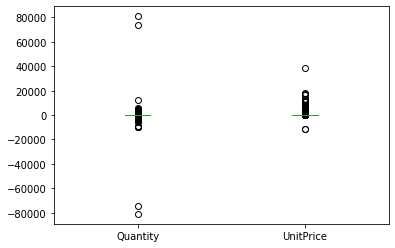

In [7]:
# let's visualize the distribution of quantity and unit price
# outliers shown as individual circles

df.boxplot(column=['Quantity', 'UnitPrice'], grid=False)

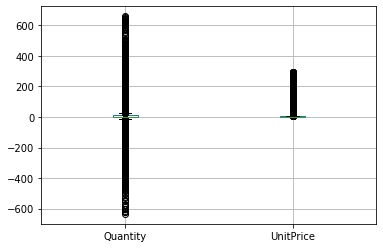

In [8]:
clean_flag = True #change it to True if you want to clean the data

if (clean_flag):
    # cleaning.
    # as a standard cleaning, we will remove entries that are more than 3 standard deviations away from the mean
    # https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
    from scipy import stats
    import numpy as np
    df = df[(np.abs(stats.zscore(df['Quantity'])) < 3)]
    df = df[(np.abs(stats.zscore(df['UnitPrice'])) < 3)]
    # let's visualize the distribution of quantity and unit price
    df.boxplot(column=['Quantity', 'UnitPrice'])
    # items with missing description will be assigned an empty string
    df["Description"] = df["Description"].fillna('')


In [ ]:
if clean_flag:
        # let's see the data again
        df.describe() # we see we have negative quantities but we accept them because we consider them as items being returned

In [9]:
# inserting the data to MongoDB
transactions.insert_many(df.to_dict('records'))
# Check the collections
db.list_collection_names()

['transactions']

In [10]:
# Grouping all transactions by invoice
transactions_per_invoice = db.transactions.aggregate([
    {"$group" : 
     {'_id':"$InvoiceNo",
     "StockCode": { "$addToSet": "$StockCode" },
     "Country": { "$addToSet": "$Country" }
     }}
])

In [11]:
# Showing the results
for transaction in transactions_per_invoice:
    print(" * InvoiceNo = {InvoiceNo}, StockCodes = {StockCode}, Countries = {Country}".format(
         InvoiceNo=transaction["_id"],
         StockCode=transaction["StockCode"],
         Country=transaction["Country"],
   ))

 * InvoiceNo = 538195, StockCodes = ['48184', '48116'], Countries = ['United Kingdom']
 * InvoiceNo = 561669, StockCodes = ['23293', '22423', '23294', '23297', 'POST', '23296', '22960', '23295'], Countries = ['Spain']
 * InvoiceNo = 579742, StockCodes = ['85204'], Countries = ['United Kingdom']
 * InvoiceNo = 556913, StockCodes = ['20725', '21929', '23287', '23286', '22969', '23209', '23283', '23203', '85099B', '23288', '23285', '22411'], Countries = ['United Kingdom']
 * InvoiceNo = 560209, StockCodes = ['21888', '23342', '22538', '22541', '22605', '85178', '23256', '20697', '22776', '23050', '22499', '23229', '23294', '21912', '23161', '23194', '22993', '23018', '22560', '22530', '21890', '21754', '23164', '23052', '23254', '23169', '22027', '85054', '46000S', '22697', '23242', '22622', '22964', '22481', '22544', '23089', '22310', '22308', '23118', '85176', '21770', '21908', '23181', '84931B', '21363', '22619', '21913', '23290', '22651', '22712', '47566', '22937', '82552', '22778', '

 * InvoiceNo = 575202, StockCodes = ['21506', '23571', '23326', '23085', '22568', '23583', '22940', '23084', '23209', '21508', '23566', '21509', '22271', '22750', '23499', '22031', '23078', '20726', '21889', '85048', '21155', '21504', '23661'], Countries = ['United Kingdom']
 * InvoiceNo = 541489, StockCodes = ['84378', '20992', '21985', '22457', '22507', '22780', '21485', '21929', '22814', '84050', '22505', '48188', '22147', '22384', '20727', '22352', '22435', '22297', '20669', '47566', '48187', '70006', '20685', '85099F', '22489', '22645', '20914', '22560', '22983', '85180A', '22196', '22037', '23230', '21755', '84988', '22716', '22692', '22469', '21621', '21385', '20711', '85099B', '22168', '22577', '85064', '21506', '22131', '48138', '22415', '21314', '21559', '22847', '48129', '22295', '21564', '22195', '22382', '22491', '16156S', '21355', '22138', '21313', '22113'], Countries = ['United Kingdom']
 * InvoiceNo = C537756, StockCodes = ['84949', '21914', '21275'], Countries = ['Unit

 * InvoiceNo = 549280, StockCodes = ['22423', '84789', '47566'], Countries = ['United Kingdom']
 * InvoiceNo = 549956, StockCodes = ['22295', '85040A', '22151', '85039B', '84879', '47566'], Countries = ['United Kingdom']
 * InvoiceNo = C557895, StockCodes = ['22656'], Countries = ['United Kingdom']
 * InvoiceNo = 558761, StockCodes = ['23284', '85061W', '22906', '20752', '20754', '23207', '22219', '21382', '22405', '23245', '22629', '22662', '21156', '22630', '21034', '22620', '47591D', '23206', '22293', '22899', '21914', '20727', '20728', '23321', '22548', '21892', '22631', '21718', '22315', '20751', '22621', '22292', '23322', '22898', '23302', '20983', '22367', '20914', '21891', '22383', '21791', '21448', '20981', '21915', '20982', '22155', '82483', '22469', '21790', '23201'], Countries = ['United Kingdom']
 * InvoiceNo = 560891, StockCodes = ['22287', '22609', '23132', '23207', '22427', '21878', '22093', '22094', '84912B', '22138', '22116', '20893', '71477', '22278', '22662', '85071

 * InvoiceNo = 579141, StockCodes = ['22615', '20973', '23084', '22142', '22636', '84997B', '21094', '23571', '22071', '21719', '21722', '23379', '21386', '85183A', '47563A', '20676', '23319', '21238', '22197', '21058', '23354', '85136C', '20769', '22466', '22141', '22898', '22745', '23352', '22562', '79066K', '23082', '21990', '22555', '22266', '22495', '22560', '21086', '22144', '21731', '20748', '22747', '85202', '21584', '22249', '23320', '22086', '22786', '21064', '22666', '23198', '23504', '22331', '22564', '22607', '21724', '85194S', '22556', '22563', '23351', '22549', '51014A', '21791', '21985', '21126', '84378'], Countries = ['United Kingdom']
 * InvoiceNo = 579142, StockCodes = ['22274', '22554', '21704', '21481', '22940', '22992', '23080', '22754', '22600', '21791', '22753', '22560', '23282', '22551', '23076', '22603', '22273', '22602', '21790', '22981', '84580', '22975', '51014A', '51014L', '48187', '23254', '23568', '23256', '23084', '23323', '22197', '23564', '21034', '21

 * InvoiceNo = C581468, StockCodes = ['22098', '21314'], Countries = ['United Kingdom']
 * InvoiceNo = 581502, StockCodes = ['22087', '23103', '22734', '22596', '21810', '23270', '22153', '22576', '22952', '22141', '21209', '22075', '85049A', '23274', '20668', '22573', '22155', '21790', '23210'], Countries = ['United Kingdom']
 * InvoiceNo = 550980, StockCodes = ['21445'], Countries = ['United Kingdom']
 * InvoiceNo = 538197, StockCodes = ['22555', '20977', '22112', '22745', '22747', '22727', '85232B', '22562', '22746', '22725', '22554', '22748', '10135', '22556', '22557', '22563', '22728', '21754', '22551', '21034'], Countries = ['United Kingdom']
 * InvoiceNo = 544313, StockCodes = ['22999', '85150', '22998', '79062D', '23005', '84508C', '72351A', '22995', '21870', '22483', '82600', '22997', '82583', '84508B', '22616', '21166', '22908'], Countries = ['United Kingdom']
 * InvoiceNo = 541504, StockCodes = ['21485', '22111', '20685', '22386', '21533', '21430', '22690', '20914', '22411',

 * InvoiceNo = 546434, StockCodes = ['22328', '22975', '22333', '84563A', 'POST', '84563B', '22326', '22487', '22760', '84997B', '84997D', '22977', '22168', '21242', '22501'], Countries = ['Belgium']
 * InvoiceNo = 538968, StockCodes = ['21232', '22630', '22551', '21508', '21715', '22029', '20725', '22045', '22382', '21495', '22708', '22474', '20727', '22472', '22649', '21213', '21504', '22475', '21231', '22662'], Countries = ['United Kingdom']
 * InvoiceNo = 546682, StockCodes = ['22425', '22720', '47566', '22567', '85017B', '22082', '21181', '22429', '22993', '85053', '16161P', '21498', '22426', '21922', '22191', '22188', '22960', '85178', '22427', '48187', '22607', '22424'], Countries = ['United Kingdom']
 * InvoiceNo = 569336, StockCodes = ['23312', '22720', '47566', '23234', '23013', '22619', '22712', '23245', '22715', '22029', '22113', '21181', '21169', '23184', '23542', '23012', '85048', '47590A', '22197', '23300', '22714', '84030E', '22086', '23181', '22984', '23093', '23080', 

 * InvoiceNo = 546646, StockCodes = ['22548', '84519B', '22178', '22375', '84596E', '21790', '20981', '22197', '84596B', '85123A', '21399', '21397', '22789', '71459', '21398', '84978', '22306', '21791', '22374', '22219', '85159A'], Countries = ['United Kingdom']
 * InvoiceNo = 547501, StockCodes = ['23127'], Countries = ['United Kingdom']
 * InvoiceNo = 544081, StockCodes = ['22699', '21868', '22523', '22520', '22522', '22423', '22521', '22515', '22514', '22485', '22310', '22698', '22697'], Countries = ['United Kingdom']
 * InvoiceNo = 537424, StockCodes = ['21730', '85123A', '22178'], Countries = ['United Kingdom']
 * InvoiceNo = 537451, StockCodes = ['84881'], Countries = ['United Kingdom']
 * InvoiceNo = 576764, StockCodes = ['16008'], Countries = ['United Kingdom']
 * InvoiceNo = 569215, StockCodes = ['22994', '84978', '23296', '22091', '85152', '23204', '23234', '21169', '21181', '22356', '22339', '23199', '23200', '22386', '22197', '22411', '22995', '20712', '22099', '22336', '23

 * InvoiceNo = 538499, StockCodes = ['20748', '22423'], Countries = ['United Kingdom']
 * InvoiceNo = 565802, StockCodes = ['22138', '23326', '20839', '22673', '23186', '22671', '23328', '20846', '22495', '84879', '22115'], Countries = ['United Kingdom']
 * InvoiceNo = 561565, StockCodes = ['35965'], Countries = ['United Kingdom']
 * InvoiceNo = 576419, StockCodes = ['85036B'], Countries = ['United Kingdom']
 * InvoiceNo = 556242, StockCodes = ['21700'], Countries = ['United Kingdom']
 * InvoiceNo = 573494, StockCodes = ['47503H'], Countries = ['United Kingdom']
 * InvoiceNo = 540149, StockCodes = ['85099C', '85099F', '84992', '21929', '71459', '21232', '21928', '84946', '84997B', '84997D', '21931', '85099B', '84997C', '84991', '21155', '20676', '84997A', '21977', '21213', '21975', '47559B', '20914', '21231', '21154'], Countries = ['United Kingdom']
 * InvoiceNo = 574300, StockCodes = ['20931', '85174', '22807', '20932', '21694', '20936', '21688', '22811', '21695', '20831', '23084', '2

 * InvoiceNo = 571734, StockCodes = ['23074', '22465', '23483', '22103', '20727', '22382', '22355', '22224', '20724'], Countries = ['United Kingdom']
 * InvoiceNo = 555920, StockCodes = ['21955', '20685', '48187', '22783', '48194', '22690', '48188', '23284', '48173C', '48138', '48185', '21523'], Countries = ['United Kingdom']
 * InvoiceNo = 537901, StockCodes = ['22423', '20749', '22469'], Countries = ['United Kingdom']
 * InvoiceNo = C550356, StockCodes = ['22907', '20794'], Countries = ['United Kingdom']
 * InvoiceNo = 549581, StockCodes = ['85099B', '22427', '22149', '22982', '22969', '22978', '22722', '22989', '22907'], Countries = ['United Kingdom']
 * InvoiceNo = 568365, StockCodes = ['84663A'], Countries = ['United Kingdom']
 * InvoiceNo = 566061, StockCodes = ['23292', '22726', '23289', '23032', '21669', '21673', '23031', '82486', '23291', '82494L', '82484', '23290', '23029', '21706', '84792', '79321'], Countries = ['United Kingdom']
 * InvoiceNo = 571294, StockCodes = ['23503'

 * InvoiceNo = 549281, StockCodes = ['22693', '21891', '21888', '23076', '21890', '21716', '21912', '22149', '22894', '21878', '21930', '21929', '23078', '22908', '21124', '47566', '21931', '22090', '21892', '47566B', '21913', '21121', '85099F', '21123', '21122', '22896', '22897'], Countries = ['United Kingdom']
 * InvoiceNo = 566592, StockCodes = ['23265', '47590A', '22997', '23263', '23266', '21154', '22954', '21194', '21035', '47590B', '21208', '82581', '22996', '21209', '82580', '23002', '22994'], Countries = ['United Kingdom']
 * InvoiceNo = 543598, StockCodes = ['21463', '21864', '82578', '21181', '21169', '21892', '82001S', '48138', '82580', '82551', '21100', '21911', '21464', '21165', '21174', '22412', '21175', '21161'], Countries = ['United Kingdom']
 * InvoiceNo = 574070, StockCodes = ['23202', '23206', '22385', '20727', '23200', '85034C', '85036C', '22411', '85025B', '22384', '85099F', '85099C', '21928', '85099B', '21931', '85034A'], Countries = ['United Kingdom']
 * Invoice

 * InvoiceNo = 581334, StockCodes = ['84510A', '22841', '22666', '23548', '21865', '23321', '21935', '21866', '21668', '22077', '23210', '22212', '20724', '22383', '22663', '22092', '23148', '22917', '23213', '23224', '22041', '22593', '22921', '22384', '23266', '84828', '23214', '23191', '22309', '20961', '22953', '21926', '22594', '23211', '20978', '84920', '21864', '23241', '22430', '22469', '23221', '23228', '35471D', '23399', '22439', '85123A', '22196', '20969', '20973', '84032A', '21232', '21181', '21262', '23407', '23264', '21479', '23395', '22775', '23265', '23179', '21889', '22179', '79321', '23322', '84375', '22893', '47421', '22807', '84519B', '22941', '72351A', '21485', '21985', '21174', '23220', '22757', '84031B', '21137', '22475', '23075', '22464', '23192', '20975', '22916', '85199S', '85174', '20727', '22920', '23263', '22420', '22918', '23081', '84032B', '22365', '22308', '22758', '23103', '22473', '22756', '84031A', '22498', '22919', '21867', '22993', '22150', '23194',

 * InvoiceNo = 575987, StockCodes = ['23518', '23511'], Countries = ['United Kingdom']
 * InvoiceNo = 545645, StockCodes = ['22652', '22968', '22654'], Countries = ['Japan']
 * InvoiceNo = 575164, StockCodes = ['48187', '23409', '82494L', '47590B', '23408', '22907', '22464', '22969', '23483', '23485', '22627', '22768', '22909', '85123A', '22169', '23077', '23328', '47590A', '85066', '23456', '22170', '23093', '23457', '23227', '23226', '23286'], Countries = ['United Kingdom']
 * InvoiceNo = 576568, StockCodes = ['23480', '21912', '22386', '20724', '22385', '23343', '85099B', '22661', '22356', '23534', '23108', '22969', '22138', '23084'], Countries = ['United Kingdom']
 * InvoiceNo = 571942, StockCodes = ['23426', '84806B', '21485', '84279P', '22845', '20974', '23400', '23660', '21408', '23482', '22112', '85152', '20992', '21158', '22487', '23427', '21166', '22111', '21544', '22844', '20996'], Countries = ['United Kingdom']
 * InvoiceNo = C539574, StockCodes = ['22768', '22766'], Countr

 * InvoiceNo = 578149, StockCodes = ['23199', '84970s', '23559', '84970l', '21929', '23501', '22694', '22844', '22813', '75049L', '22358', '23136', '23317', '23341', '22083', '22077', '22178', '22376', '22422', '22699', '22972', '23388', '21035', '23013', '23424', '22900', '21156', '23329', '22384', '23480', '22468', '85114b', '21864', '21931', '22488', '21259', '22200', '82580', '23014', '23352', '22550', '84755', '23301', '21989', '20969', '22196', '22076', '22300', '22085', '22175', '21181', '22378', '21115', '22689', '22191', '21875', '23400', '22553', '23012', '21558', '23406', '23570', '22154', '82001s', '23365', '20712', '22668', '23239', '85049a', '85049e', '20676', '22659', '23391', '23243', '22179', '22301', '48194', '22406', '22507', '22271', '22654', '22139', '22671', '23201', '37340', '21328', '23404', '20669', '22381', '22916', '23127', '22619', '85099C', '21731', '22918', '23118', '82552', '21216', '21934', '22411', '22474', '21843', '22187', '22352', '23346', '22947', '

 * InvoiceNo = 573979, StockCodes = ['35968'], Countries = ['United Kingdom']
 * InvoiceNo = 551439, StockCodes = ['22766', '21035', '22762', '47566', '84916', '22303', '21399', '22180', '85066', '22169', '22768', '21843', '82486', '84687', '22456', '22894'], Countries = ['United Kingdom']
 * InvoiceNo = 579733, StockCodes = ['84581'], Countries = ['United Kingdom']
 * InvoiceNo = 550781, StockCodes = ['84597B', '84563A', '85159B', '84358', '37327', '37370', '84563B', '22781', '22423', '22848', '79066K', '21658', '22849', '22719', '47566', '21868', '84597C', '84313C', '79030G'], Countries = ['United Kingdom']
 * InvoiceNo = 552550, StockCodes = ['22993', '22666', '22348', '22621', '22969', '84050', '48138', '22722', '22607', '21704', '21181', '82582', '23284', '22961', '22084', '23298', '21977'], Countries = ['United Kingdom']
 * InvoiceNo = 563465, StockCodes = ['22488', '22457', '22456', '22185'], Countries = ['United Kingdom']
 * InvoiceNo = 553997, StockCodes = ['15058B', '22382', 

 * InvoiceNo = 573381, StockCodes = ['22759', '22910', '85034A', '22086', '22161', '22992', '23321', '23583', '23280', '23491', '22158', '23082', '23348', '23247', '23159', '22155', '20992', '23489', '23282', '85034C', '35471D', '23156', '22972', '84944', '22974', '23154', '22975', '22703', '71038', '21340', '22374', '22977', '23076', '23344', '23320', '21326', '23090', '22801', '23109', '23110', '84946', '23355', '23084', '23266', '23263', '22154', '84659A', '23319', '23551', '23480', '23264', '23227', '23375', '21756'], Countries = ['United Kingdom']
 * InvoiceNo = 580027, StockCodes = ['21382', '22489', '22834', '21918', '20723', '84251G', '22865', '21871', '23694', '22998', '22286', '22161', '23445', '21704', '22996', '22139', '85194S', '22492', '23366', '23016', '20719', '22475', '22866', '23439', '22138', '22629', '22097', '20973', '23084', '23507', '23509', '16219', '23378', '84077', '22609', '22633', '23506', '22287', '21563', '21914', '22535', '22630', '84012', '22028', '23077

 * InvoiceNo = 551982, StockCodes = ['22982', '48138', '22437', 'M', '21937', '22434', '22384', '21987', '23283', '85099B', '20727', '20711', '20717', '21340', '22749', '22477', '20726', '20622', '22692', '21989', '22993', '22429', '85123A', '22063', '22439', '22750', '11001', '22055', '21243', '21524', '84077', '21609', '22665', '22890', '21868', '20718', '84792', '22926', '21559', '23207', '84879', '20728', '22491', '48129', '22605', '21558', '22721', '20712', '22980', '84380', '21613', '22326', '22440', '20725', '22989', '21929', '22666', '22479', '22478', '20654', '16049', '22751', '23146', '22329', '51014A', '23201', '51014L', '23284', '22981', '23068', '48194', '20992', '16237', '22383', '22423', '20974', '22645', '20677', '21933', '21211', '21876', '22327', '21930', '21714', '20685', '48187', '22431', '22965', '21988', '22386', '71053', '20670', '21239', '85040A', '62018', '23298', '22149', '48188', '23147', '21614', '84563B', '22147'], Countries = ['United Kingdom']
 * InvoiceN

 * InvoiceNo = 566446, StockCodes = ['21866', '21914', '21944', '22595', '23199', '35916B', '22653', '23349', '22197', '22095', '22074', '20828', '15056N', '22727', '21314', '22728', '22963', '20713', '21787', '22029', '21356', '21166', '22356', '22452', '22661', '17012C', '22105', '22499', '22617', '23355', '82484', '84879', '22109', '22678', '23169', '23182', '46776A', '21912', '21867', '22946', '21890', '22530', '21086', '21733', '22560', '22686', '21381', '23089', '22962', '21163', '21407', '22027', '22588', '22758', '22697', '21080', '85099B', '22815', '22355', '23205', '21908', '90086', '21843', '22738', '22759', '46776E', '84598', '21934', '23611', '22282', '21172', '22464', '21494', '22801', '85032C', '84912B', '22619', '85099C', '22366', '22381', '23171', '47566', '22671', '21915', '22114', '22456', '22139', '17012D', '22507', '22534', '23356', '23328', '22301', '23124', '22741', '23072', '85049H', '22621', '23376', '84050', '21803', '85039A', '23170', '22608', '21992', '22440

 * InvoiceNo = 575882, StockCodes = ['85049A'], Countries = ['United Kingdom']
 * InvoiceNo = 555198, StockCodes = ['22427', '84508A', '22165', '84508B', '22625', '22040', '22423', '22430', '22038'], Countries = ['United Kingdom']
 * InvoiceNo = C560652, StockCodes = ['23202', '23206'], Countries = ['United Kingdom']
 * InvoiceNo = 550288, StockCodes = ['22752', '22230', '17003', '22934', '20757', '22322', '21745', '22321', '37342', '85208', '85049G', '84748', '21428', '22245', '23002', '35924', '85049A', '22454', '21122', '22244', '22969', '22995', '20756', '20758', '21430', '21034', '20755', '21770', '20760', '22231', '22085', '21124', '21121'], Countries = ['United Kingdom']
 * InvoiceNo = C560654, StockCodes = ['23026', '23147'], Countries = ['United Kingdom']
 * InvoiceNo = C545997, StockCodes = ['21156', '22367', '22634'], Countries = ['France']
 * InvoiceNo = 563721, StockCodes = ['84992', '23204', '23344', '22356', '20723', '20719', '22661', '22355', '23205', '21212', '23343', 

 * InvoiceNo = 543466, StockCodes = ['22926', '21071', '22087', '22481', '22424', '21070', '22855', '22335', '84946', '21658', '84836', '21871', '22480', '22457', '21069', '15056N', '22429', '22482', '71053', '21485'], Countries = ['United Kingdom']
 * InvoiceNo = 570653, StockCodes = ['23526', '23535', '23136', '23169', '23013', '23124', '84945', '23283', '23186', '23520', '84947', '85062', '23190', '23019', '16014', '23137', '22197', '22169', '22982', '23125', '22411', '23187', '85099C', '35095A', '23192', '23185', '22382', '35095B', '20685'], Countries = ['United Kingdom']
 * InvoiceNo = 558241, StockCodes = ['21386', '37342', '22161', '22427', '23321', '21391', '22429', '22469', '23187'], Countries = ['United Kingdom']
 * InvoiceNo = 563731, StockCodes = ['23333', '23330', '23206', '22077', '21429', '21430', '21902', '22993', '22626', '21407', '22989', '23322', '22666', '23209', '23332', '22624', '22665'], Countries = ['United Kingdom']
 * InvoiceNo = C580507, StockCodes = ['72351B

 * InvoiceNo = C540555, StockCodes = ['21527', '22617'], Countries = ['United Kingdom']
 * InvoiceNo = C557649, StockCodes = ['21735'], Countries = ['United Kingdom']
 * InvoiceNo = 570593, StockCodes = ['22578', '90012A', '22197', '22475', '22371', '35953', '21818', '22695', '90000D', '90012B', '21819', '22579', '22473', '21823', '21824', '23434', '22338', '23435', '22577', '21579', '22696', '22340', '90000A', '35964'], Countries = ['United Kingdom']
 * InvoiceNo = 546992, StockCodes = ['22654', '22629', '82482', '22960', '22699', '22659', '22697', '22741', '21166', '15036', '21977', '22766', '15056N', '82600', '22993', '22423'], Countries = ['United Kingdom']
 * InvoiceNo = C557478, StockCodes = ['22720'], Countries = ['United Kingdom']
 * InvoiceNo = 577138, StockCodes = ['20936'], Countries = ['United Kingdom']
 * InvoiceNo = 579443, StockCodes = ['23255', '22746', '22992', '23503', '23504', '22747', '21070', '21875', '23016', '21068', '21871', '22197', '21877', '22748'], Countries

 * InvoiceNo = 576615, StockCodes = ['21981', '22579', '84406B', '22529', '22535', '23423', '23395', '21818', '82582', '22766', '22572', '23188', '22553', '23349', '23300', '22739', '23084', '23090', '22533', '84792', '23558', '84879', '21819', '21822', '22530', '21754', '22467', '23301', '22555', '22731', '22733', '21165', '22578', '23082', '22536', '22577', '21810', '23157', '46000S', '21984', '23181', '23026', '21756', '21014', '22557', '23393', '21908', '23353', '23551', '23456', '23694', '23131', '21015', '21172', '21261', '23104', '21352', '22737', '22546', '23455', '21485', '23351', '21982', '21745', '23697', '22563', '22556', '21175', '22531', '21985', '22736', '22423', '23524', '22909', '22532', '22734', '85125', '22564', '22111'], Countries = ['United Kingdom']
 * InvoiceNo = 554035, StockCodes = ['22847', '23088', '23086', '23087'], Countries = ['United Kingdom']
 * InvoiceNo = 545875, StockCodes = ['21736'], Countries = ['United Kingdom']
 * InvoiceNo = 549837, StockCodes =

 * InvoiceNo = 550330, StockCodes = ['22938', '23159', '22993'], Countries = ['United Kingdom']
 * InvoiceNo = 549451, StockCodes = ['22192', '22295', '22178', '22986', '22984', '22193', '22423', '48194', '23232', '23177', '22907', '22817', '48138', '20685', '22712', '22090', '22720', '47566'], Countries = ['United Kingdom']
 * InvoiceNo = 560534, StockCodes = ['23282', '21524', '22348', '21523', '23245', '21658', '23202', '21892', '22460', '21704', '23281', '84077', '22178', '22821', '21790', '22652', '23052', '21915', '22197', 'C2', '22620', '22991', '22028', '23049', '21912'], Countries = ['EIRE']
 * InvoiceNo = C557142, StockCodes = ['84378', '22965'], Countries = ['France']
 * InvoiceNo = 558197, StockCodes = ['22230', '21562', '22233', '21209', '21382', '21208', '84212', '16218', '22286', '20996', '35471D', '62018', '22231', '21194', '16048', '22287', '22268', '22266', '22267', '20992'], Countries = ['United Kingdom']
 * InvoiceNo = 561518, StockCodes = ['21090', '23295', '23166'

 * InvoiceNo = 549148, StockCodes = ['84406B', '84674', '22212', '71053', '22822', '21714', '22233', '23232', '22993', '22784', '21466', '22991', '22411', '84872A', '22433', '71459', '21469', '84796B', '22992', '23233', '21579', '84673B', '20751'], Countries = ['United Kingdom']
 * InvoiceNo = 546957, StockCodes = ['90068', '90065A', '90030B', '90212C', '90031', '90210C', '90075', '90210A', '90212B'], Countries = ['United Kingdom']
 * InvoiceNo = 559132, StockCodes = ['23077', '22565', '22076', '21791', '23229', '20981', '20982', '22610', '22748', '20727', '20726', '22746', '22992', '22090', '84673B', '23207', '22747', '23310', '22949', '22745'], Countries = ['United Kingdom']
 * InvoiceNo = 560357, StockCodes = ['20712', '21471', '22636', '23173', '20727', '22699', '23237', '22988', '22752', '23550', '23203'], Countries = ['United Kingdom']
 * InvoiceNo = 566226, StockCodes = ['22513', '21706', '22457', '21181', '21707', '22802', '21485', '20682', '20686', '21462', '23355'], Countries

 * InvoiceNo = 571829, StockCodes = ['22993', '48188', '85034B', '22193', '21980', '22076', '22423', '22139', '22549', '22294', '22077', '84832', '22585', '21588', '22605', '48187', '22111', '84970L', '85152', '22113', '21983', '21172', '22112'], Countries = ['United Kingdom']
 * InvoiceNo = 545224, StockCodes = ['47590A', '20726', '22386', '22664', '20727', '22379', '22377', '85099F', '22383', '47590B', '22381'], Countries = ['United Kingdom']
 * InvoiceNo = 551534, StockCodes = ['21723', '22436', '85099B', '21931', '21928', '21929', '84970L', '22411', '23077', '23076', '23144', '23199', '22386', '22652'], Countries = ['United Kingdom']
 * InvoiceNo = 565463, StockCodes = ['23378', '22077', '22952', '84946', '23351', '22950', '23129', '22423', '23319', '23350', '23354', '22086', '22734'], Countries = ['United Kingdom']
 * InvoiceNo = 554057, StockCodes = ['21631', '47599A', '72351B', '18097C'], Countries = ['United Kingdom']
 * InvoiceNo = 561919, StockCodes = ['85017B'], Countries = 

 * InvoiceNo = 538353, StockCodes = ['84596E', '21903', '84596B', '21165', '84596F', '21700', '21733', '20914', '21231', '22065', '21928', '84596G', '90200D', '90200E', '35924', '84970L', '37447', '37446', '21212', '37450', '85099B', '37449', '90200B', '47599B', '84380', '47559B', '21232', '22470', '21562', '82583', '85099C', '48185', '22064', '90200C', '21166', '21181', '20685'], Countries = ['United Kingdom']
 * InvoiceNo = 580754, StockCodes = ['20724', '22895', '20675', '21484', '22356', '23207', '21668', '23358', '35970', '20719', '21670', '84029E', '22423', '84029G', '21672', '22383', '22736', '22426', '21671', '22725', '22111', '22896', '20727', '22943', '22748', '22738', '21673', '22834', '22772', '22747', '22112', '20723', '84997c', '47566', '22737', '85049g', '84030e', '23301', '84347', '22805', '22898', '21481', '21212', '22355', '22110', '22735', '22910', '23205', '22775', '23206', '21479', '22197', '21238', '21244', '22726', '82583', '21243', '23168', '23084', '22727', '23

 * InvoiceNo = 558353, StockCodes = ['22616'], Countries = ['United Kingdom']
 * InvoiceNo = 565461, StockCodes = ['22488', '22274', '22568', '22940', '22144', '22570', '22142', '22487', '22457', '22565', '22147', '22566', '22569', '22751', '23298'], Countries = ['United Kingdom']
 * InvoiceNo = C581322, StockCodes = ['22666', '22909'], Countries = ['United Kingdom']
 * InvoiceNo = 546683, StockCodes = ['85231G', '22027', '22178', '22176', '22595', '21314', '22149', '22718', '37444A', '22698', '21556', '82482', '22666', '22960', '22699', '22720', '84879', '22460'], Countries = ['United Kingdom']
 * InvoiceNo = 566615, StockCodes = ['23084'], Countries = ['United Kingdom']
 * InvoiceNo = 563013, StockCodes = ['22382', '20725', '20728', '23201', '84997B', '21790', '21429', '22561', '22662', '21791', '84997C', '22384'], Countries = ['United Kingdom']
 * InvoiceNo = 539246, StockCodes = ['20780', '21647', '84509A', '20886', '21657', '20757', '22316', '22196', '85114C', '21934', '21846', '8

 * InvoiceNo = 552357, StockCodes = ['84978', '22845', '23298', '23132', '84879', '22771', '85123A', '22423', '22892', '23284', '82482', '23070', '22969'], Countries = ['United Kingdom']
 * InvoiceNo = 557311, StockCodes = ['48187', '72741', '23254', '21755', '21617', '23156', '21932', '22467', '84596F', '21623', '84596B', '21452', '84755', '84971S', '21754', '21033', '23302', '22093', '21618', '23301', '23288', '21428', '22646', '21242', '23202', '20674', '22488', '20676', '22644', '84509A', '22894', '22372', '22371', '22847', '21244', '21238', '21613', '23300', '21390', '82583', '21524', '21243', '21609', '21868', '23256', '21620', '21166', '20718', '22374', '20675', '23154', '22376', '23284', '23203', '21240', '22507', '23159', '22922', '21164', '22969', '84510A', '82551', '22666', '23255', '85038', '23153', '23298', '21239', '21756', '22297', '22296', '22099', '22411', '22413', '21245', '22667', '21615', '84849D', '20677', '21172', '82552', '22720', '23184', '22079'], Countries = [

 * InvoiceNo = 556243, StockCodes = ['21981', '15036', '22502', '21401', '23199', '22605', '22838', '23300', '23245', '21967', '22094', '22499', '22776', '23168', '23110', '21383', '37501', '20726', '20901', '21581', '23309', '21108', '22800', '22752', '22919', '48138', '16020C', '21829', '21381', '22697', '20980', '22355', '15058B', '21544', '22554', '22791', '21202', '23205', '84569D', '20727', '22920', '21374', '23144', '84748', '21430', '22918', '71459', '21900', '71143', '22088', '90039D', '85032C', '21172', '21731', '20897', '20754', '23171', '85032A', '21993', '22916', '84638', '85086A', '90214I', '21174', '20725', '21389', '22616', '35004B', '84569A', '16207B', '21880', '47574A', '84637', '85131D', '21415', '85049G', '23206', '20682', '21380', '21906', '22775', '23172', '22553', '22326', '20661', '22689', '20707', '35653', '84997B', '22424', '21868', '21041', '85131B', '22508', '23204', '21625', '90014A', '21680', '84754', '22174', '22692', '90214T', '21716', '23301', '85123A',

 * InvoiceNo = 580093, StockCodes = ['22580', '22186'], Countries = ['United Kingdom']
 * InvoiceNo = 580893, StockCodes = ['23579', '15056N', '22930', '85014A', '22115', '23395', '85071C', '21563', '22942', '21166', '21181', '22509', '23275', '22123', '23396', '21355', '23109', '22500', '21162', '21158', '23016', '20914', '23301', '20992', '23392', '21165', '22642', '84820', '79157B', '23535', '21175', '15056BL', '84817', '85034C', '21713', '22596', '23321', '21524', '23123', '22481', '23580', '21592', '82551', '22562'], Countries = ['United Kingdom']
 * InvoiceNo = 581174, StockCodes = ['21705', '22811', '22114', '21790', '85150', '21733', '85123A', '84945', '71477', '22113', '84946', '22112', '23355', '21730', '21181', '22835'], Countries = ['United Kingdom']
 * InvoiceNo = 573375, StockCodes = ['23255', '23201', '23256', '23207', '22382', '22491', '22622', '23571', '22489', '22331', '23209', '21731', '23084', '21889', '22560', '20712', '21238', '23569', '23254', '21915', '23206', '

 * InvoiceNo = 569726, StockCodes = ['22456', '71053', '23182', '20971', '22297', '21889', '22693', '21891', '21890', '22189', '85123A', '22457', '22620', '22138', '84970L', '22739', '23355', '22689', '84792', '23399', '22568', '22537'], Countries = ['United Kingdom']
 * InvoiceNo = 572553, StockCodes = ['23368', '22980', '23012', '23188', '22190', '23327', '22154', '85227', '22599', '23287', '23365', '20755', '21992', '22703', '23558', '82583', '21012', '22255', '22944', '21441', '23367', '84596B', '84596F', '85123A', '23434', '21822', '82567', '23241', '23211', '22488', '22158', '22578', '22434', '21679', '22065', '23014', '23332', '23542', '82580', '21905', '22384', '22982', '22581', '22846', '23462', '17084N', '23175', '22699', '22979', '23318', '23620', '22340', '23396', '21162', '21918', '22112', '84978', '23184', '20719', '21175', '23136', '23210', '46775D', '85203', '22077', '47593B', '23388', '21167', '21418', '21907', '72586', '22579', '23307', '23559', '71279', '22694', '208

 * InvoiceNo = 568648, StockCodes = ['22725', '22467', '22726', '22727'], Countries = ['United Kingdom']
 * InvoiceNo = 581459, StockCodes = ['22197'], Countries = ['United Kingdom']
 * InvoiceNo = 563704, StockCodes = ['37342'], Countries = ['United Kingdom']
 * InvoiceNo = C579948, StockCodes = ['21098', '21730', '21822'], Countries = ['United Kingdom']
 * InvoiceNo = 570695, StockCodes = ['23215', '23310', '23264', '23223', '23367', '23368', '22593', '21703', '20982', '22909', '23274', '23445', '20983'], Countries = ['United Kingdom']
 * InvoiceNo = C558471, StockCodes = ['22974'], Countries = ['Belgium']
 * InvoiceNo = 562721, StockCodes = ['22918', '22845', '22702', '22916', '21165', '22917', '22844', '22652', '22920', '22919'], Countries = ['United Kingdom']
 * InvoiceNo = 539500, StockCodes = ['72802B'], Countries = ['Bahrain']
 * InvoiceNo = 557280, StockCodes = ['21495', '79051A', '23084', '22710', '21507', '21504', '79163', '22708', '21975', '23284', '23122', '23120', '22712'

 * InvoiceNo = 554132, StockCodes = ['22555', '23159', '21989', '22551', '23010', '21086', '22693', 'POST', '22556', '84997A', '22438', '22492', '21240', '21723', '22554', '22328', '21080', '21676', '21242', '23255', '85185B', '21987', '22433', '22621', '22326', '21244', '21561', '21675', '21558', '22557', '21988', '23008', '21559', '22352', '22431', '23128', '23155', '20676', '23256', '84674', '84997D', '20677', '21094', '23007', '21245'], Countries = ['Austria']
 * InvoiceNo = 555635, StockCodes = ['23165', '23172', '23203', '23284', '23201', '23205', '23171', '23170', '23204', '23202', '23166', '23108', '23208', '23209', '23283'], Countries = ['United Kingdom']
 * InvoiceNo = 540828, StockCodes = ['21912', '22423', '22082', '20728', '21427', '21479', '22077', '21080', '20723', '21866', '21864', '22110', '21425', '22079', '22355', '22378', '22725', '22734', '85099f', '22727'], Countries = ['United Kingdom']
 * InvoiceNo = C545456, StockCodes = ['21527', '21231', '22697'], Countries =

 * InvoiceNo = C553877, StockCodes = ['22960', '21533'], Countries = ['United Kingdom']
 * InvoiceNo = C546906, StockCodes = ['82484'], Countries = ['United Kingdom']
 * InvoiceNo = 561706, StockCodes = ['22727', '22730', '21928', '23203', '22729', '22726', '71459', '22725', '85099B', '22728'], Countries = ['United Kingdom']
 * InvoiceNo = 536866, StockCodes = ['72803b'], Countries = ['United Kingdom']
 * InvoiceNo = 574502, StockCodes = ['23242', '23360', '23271', '23182', '23324', '23499', '23300', '23294', '23325', '23301', '23165', '23194', '21916', '23177', '23355', '22963', '23295', '23193', '22962', '23504', '23503', '23084', '23252', '23241'], Countries = ['United Kingdom']
 * InvoiceNo = 536583, StockCodes = ['21156'], Countries = ['United Kingdom']
 * InvoiceNo = 552514, StockCodes = ['20719', '84078A', '23162', '22698', '37342', '85203', '84247G', '22412', '72586', '22399', '23284', '84212', '17129F', '84536A', '84692', '21935', '22989', '22922', '22502', '22969', '84970L', 

 * InvoiceNo = 536404, StockCodes = ['22773', '22469', '21126', '22964', '22417', '85049C', '22383', '84378', '22805', '21063', '84992', '85049E', '85049G', '21212', '22297', '21975', '22296', '20728', '21061', '85049D', '21213', '22197', '20727', '21062', '84380', '21125', '22772', '22771'], Countries = ['United Kingdom']
 * InvoiceNo = 563748, StockCodes = ['85199L', '22602', '23288', '23235', '23286', '23244', '23287', '22974', '21238', '23289', '23291', '22964', '21401', '22973', '84078A', '23329', '22179', '23079', '23310', '21403', '21705', '23270'], Countries = ['United Kingdom']
 * InvoiceNo = 549276, StockCodes = ['22558', '22900', '20712', '22411', '22895', '22386', '21213', '85135B', '22961', '20723', '21035', '21930', '22771', '85099B', '85099F', '22722', '22897'], Countries = ['United Kingdom']
 * InvoiceNo = 548792, StockCodes = ['22084', '85145', '21242', '21212', '22558', '21399', '82551', '22989', '85146', '21936', '37482P', '22507', '22096', '22178', '20726', '21976',

 * InvoiceNo = 575152, StockCodes = ['23510', '22565', '23508', '23348', '22411', '23491', '23332', '22536', '23215', '22596', '22254', '22791', '23103', '21915', '22586', '23169', '21116', '23039', '22178', '22587', '22255', '23313', '84945', '20975', '23083', '22138', '23109', '20973', '84946', '22142', '23084', '22979', '23492', '22533', '22546', '23333', '22537', '21032', '23571', '23330', '21833', '84077', '23190', '21914', '23480', '23329', '85089', '23188', '23570', '23382', '71459'], Countries = ['United Kingdom']
 * InvoiceNo = 577493, StockCodes = ['23582', '22562', '23198', '22745', '20725', '23209', '21928', '21929', '22564', '23307', '23308', '21931', '22436', '21212', '22746', '23583', '20971', '35471D', '23154', '23293', '22417', '22563', '20726', '20724', '22355', '20711', '23202', '23203', '21329', '20719', '23208', '22356', '22382', '23204', '21328', '23681', '23206', '21977', '21288', '22748', '20972', '22386', '22385', '22384', '23581'], Countries = ['United Kingdom

 * InvoiceNo = 566307, StockCodes = ['22086', '21479', '23373', '23319', '23354', '22812', '23083', '22687', '22952', '23314', '84946', '23109', '35970', '23374', '23318', '22113', '23234', '23351', '23344', '22941', '23273', '22114', '22584', '23343', '22592', '23436', '23356', '21733', '23274', '23247', '23376', '22909', '22734', '22596'], Countries = ['United Kingdom']
 * InvoiceNo = C580766, StockCodes = ['23301', '22840', '21430', '22667'], Countries = ['United Kingdom']
 * InvoiceNo = C577131, StockCodes = ['22827'], Countries = ['United Kingdom']
 * InvoiceNo = C536383, StockCodes = ['35004C'], Countries = ['United Kingdom']
 * InvoiceNo = 581451, StockCodes = ['22666', '21258', '22310', '21115', '21523', '22441', '22624', '22627', '22111', '22794', '22960', '23583', '22366', '22720', '48129', '22692', '23575', '23697', '48187', '23576', '84029E', '21485', '22442', '22350', '22030'], Countries = ['United Kingdom']
 * InvoiceNo = 546033, StockCodes = ['82486'], Countries = ['Unit

 * InvoiceNo = 576329, StockCodes = ['21158', '23355', '23168', '22963', '22138', '22866', '23433', '20718', '23029', '23423', '90174', '72598', '17012F', '22419', '22726', '22995', '84535B', '15056N', '22728', '85066', '90164A', '21381', '21616', '22945', '20840', '84992', '23238', '22597', '22554', '23315', '72351B', '22577', '21218', '22697', '21744', '23052', '23169', '23294', '22753', '23229', '21733', '21108', '21890', '23007', '22311', '85059', '23166', '22619', '23359', '23346', '22474', '22738', '22759', '22070', '71459', '85049H', '22505', '23209', '48111', '23376', '21164', '22659', '90182A', '23519', '22329', '90003C', '22818', '21811', '22654', '84378', '22301', '23296', '22191', '35964', '22085', '23531', '22186', '22601', '23264', '16048', '20676', '22620', '85227', '22723', '22553', '23564', '23570', '20712', '21679', '22065', '85180B', '22578', '22594', '23014', '85169B', '23080', '20978', '23241', '35471D', '21755', '22076', '85123A', '21715', '23392', '21358', '23367

 * InvoiceNo = 550476, StockCodes = ['84997B', '84997A'], Countries = ['United Kingdom']
 * InvoiceNo = 581217, StockCodes = ['22594', '22086', '21705', '20727', '22557', '72122', '85176', '90210C', '21675', '22865', '23263', '23382', '46776D', '23616', '22348', '21930', '22999', '23171', '21774', '23528', '47566', '23234', '22751', '22114', '23576', '23174', '23219', '23356', '21137', '17012D', '21985', '22513', '23220', '79144B', '22331', '22621', '22190', '22909', '85039A', '23371', '22755', '23170', '22795', '20972', '23005', '85014B', '48173C', '23579', '23380', '23349', '22565', '21390', '22629', '23197', '21094', '21620', '23571', '22064', '23196', '23535', '23530', '23343', '23133', '90146', '20914', '21329', '21231', '23212', '22591', '22315', '21650', '21519', '22622', '23216', '22791', '90022', '21990', '22156', '23377', '23214', '22360', '47471', '20733', '23191', '23694', '90054', '21327', 'DOT', '21015', '22208', '22327', '22720', '22604', '21470', '22341', '21832', '2329

 * InvoiceNo = C554005, StockCodes = ['21747'], Countries = ['United Kingdom']
 * InvoiceNo = 579159, StockCodes = ['23352', '22551', '23695', '23351', '22139', '23494', '21506', '23349', '23350'], Countries = ['United Kingdom']
 * InvoiceNo = 557295, StockCodes = ['POST', '22383', '22382', '23206', '20728', '23084', '23208'], Countries = ['France']
 * InvoiceNo = 553183, StockCodes = ['22617', '22515', '21936', '22520', '22522', '22457', '22230', '23298', '22139', '22514', '22090', '21212', '22516', '22517', '22519', '22138'], Countries = ['United Kingdom']
 * InvoiceNo = 579465, StockCodes = ['21411', '22108', '22091', '21351', '21108', '23301', '20983', '22469', '22114', '22109', '22607', '22852', '21907', '22093', '48138', '22625', '22809', '22624', '23322', '23323', '23300', '22561', '21098', '23400', '23342', '22099', '85150', '22816', '21166', '23522', '22470', '23355', '85152', '82583'], Countries = ['United Kingdom']
 * InvoiceNo = 568875, StockCodes = ['21929', '22282', '2209

 * InvoiceNo = 560590, StockCodes = ['84510A', '22960', '22728', '23198', '22302', '22303', '22989', '22624', '23307', '22725', '23243', '23308', '23174', '23293', '22895', '23244', '23289', '85053', '79191C', '20981', '22907', '22637', '22627', '23290', '22979', '22999', '23175', '23285', '23286', '84030E', '23004', '22982', '16161P', '23232', '23191', '22897', '20652', '23089', '22729', '23292', '22962', '22554', '22430', '23202', '22697', '21884', '22908', '23288', '22961', '22692', '22740', '23196', '22319', '22704', '22403', '22551', '22727', '22963', '23208', '23237', '22029', '23245', '22629', '23199', '22831', '22847', '23239', '23206', '23291', '23287', '22726', '23235', '22326', '22630', '22781', '22980'], Countries = ['Germany']
 * InvoiceNo = C559740, StockCodes = ['20985'], Countries = ['United Kingdom']
 * InvoiceNo = 541517, StockCodes = ['21232', 'POST', '21231'], Countries = ['Germany']
 * InvoiceNo = C541641, StockCodes = ['21672', '21671'], Countries = ['United Kingd

 * InvoiceNo = 572897, StockCodes = ['22456', '21955', '21181', '22090', '22424', '22952', '84032A', '21232', '85184c', '22379', '21115', '22689', '23316', '23406', '22721', '21558', '22553', '20712', '85049a', '85049e', '23239', '85150', '21786', '23176', '23157', '21259', '22328', '22430', '21864', '82613c', '21931', '20676', '20717', '84969', '23283', '23352', '82580', '21949', '22433', '20967', '47518f', '22668', '22069', '21989', '23282', '22469', '84510c', '22870', '85123a', '22219', '20685', '47590b', '22720', '22357', '22699', '22900', '22144', '22570', '21876', 'DOT', '21411', '21121', '22669', '85114b', '22386', '84970s', '21935', '21865', '22734', '21217', '21896', '22666', '23501', '21257', '21929', '22670', '22663', '22698', '75049L', '22278', '22294', '23284', '22077', '23351', '22173', '22358', '21175', '20718', '85014a', '21425', '23256', '21169', '22776', '23355', '20713', '22499', '23245', '22629', '23349', '21294', '23165', '72351a', '20828', '23199', '82494l', '2310

 * InvoiceNo = 559941, StockCodes = ['22698', '22423', '22699'], Countries = ['United Kingdom']
 * InvoiceNo = 565326, StockCodes = ['84596B', '22423', '84596F', '22663', '20992', '84378', '47593B', '23201', '15056BL', '23169', '35968', '84559A', '21071', '84559B', '21788', '20679', '20996', '22966', '21636', '84596G', '84375', '84596L', '84380', '47559B', '15056N', '22385', '22965', '21872', '21789', '21070', '22776', '22487', '21787'], Countries = ['United Kingdom']
 * InvoiceNo = 576674, StockCodes = ['21823'], Countries = ['United Kingdom']
 * InvoiceNo = 568153, StockCodes = ['22086', '22910', '23333', '22596', '23321', '23340', '23332', '22952', '23323', '22955', '22555', '23100', '23329', '23078', '23311', '23330'], Countries = ['United Kingdom']
 * InvoiceNo = 556516, StockCodes = ['21430', '21901', '21929', '22680', '22502', '20711', '22501', '21931', '22925', '21218', '22961', '22972', '21936', '21989', '22993', '21974', '22055', 'DOT', '21424', '20718', '22325', '23199', '21

 * InvoiceNo = 566577, StockCodes = ['22699', '23285', '22381', '22720', '15056n', '20726', '85123a', '21035', 'DOT', '85099C', '22677', '48185', '23000', '21790', '21731', '22900', '48184', '21930', '21948', '21156', '21430', '22144', '22411', '22385', '22386', '22352', '23286', '47566b', '22086', '21770', '22659', '22161', '22966', '84970l', '84970s', '85114c', '22207', '22616', '22844', '22666', '22960', '21217', '22179', '22663', '22457', '22358', '15056bl', '22173', '84029G', '22077', '22422', '22424', '22378', '22771', '85014a', '20718', '22629', '23245', '22379', '20713', '82482', '23084', '22776', '22952', '85014b', '85040a', '22630', '20712', '21682', '23287', '22668', '82494l', '85049a', '23199', '23288', '85099B', '22622', '20711', '22430', '21931', '22488', '22200', '22634', '82580', '21949', '21928', '82600', '22993', '22069', '22752', '23182', '22109', '22975', '23196', '22961'], Countries = ['United Kingdom']
 * InvoiceNo = 571901, StockCodes = ['22504', '22503'], Countr

 * InvoiceNo = 569457, StockCodes = ['84978', '22348', '22429', '22196', '20749', '22555', '22329', '23080', '23006', '22274', '85170D', '85231G', '90214A', '22532', '84050', '22303', '22302', '21666', '20961', '23081', '20668', '21354', '22297', '22557', '21944', '21035', '22195', '20713', '21094', '22517'], Countries = ['United Kingdom']
 * InvoiceNo = 577603, StockCodes = ['23009', '21051', '84945', '23375', '15056BL', '22571', '21464', '21463', '22725', '23436', '85015', '22818'], Countries = ['United Kingdom']
 * InvoiceNo = 548629, StockCodes = ['21749'], Countries = ['United Kingdom']
 * InvoiceNo = 569900, StockCodes = ['35953', '22571', '22144', '21015', '22944', '85099F', '20723', '47566', '21014', '20727', '22333', '22332', '22384', '20668', '22149', '22662', '22331', '20725', '22579', '22338', '20971', '23201', '72816', '20724', '21373', '22383', '22663', '20992', '23208', '22142', '35970', '22334', '20713', '35964', '22339', '22382', '22186', '16218', '22118', '23199', '23

 * InvoiceNo = 572442, StockCodes = ['22445', '23388', '22748', '23434', '22750', '21452', '20719', 'POST', '20969', '48194', '22745', '22142', '22144', '22141', '22505', '23480', '22747', '21576', '22739', '20970', '22564', '22746', '21580', '22735'], Countries = ['Spain']
 * InvoiceNo = 568943, StockCodes = ['22988', '22619', '22902', '22616', '23309'], Countries = ['United Kingdom']
 * InvoiceNo = 570121, StockCodes = ['22759', '21984', '21986', '21980', '22983', '16161P', '22632', '21985', '85099C', '21497', '22867', '22866', '22985', '21519', '85099B', '21506'], Countries = ['United Kingdom']
 * InvoiceNo = C581499, StockCodes = ['M'], Countries = ['United Kingdom']
 * InvoiceNo = 559935, StockCodes = ['23203', '22846', '22892'], Countries = ['United Kingdom']
 * InvoiceNo = 558069, StockCodes = ['23306', '23198', '23197', '21210'], Countries = ['EIRE']
 * InvoiceNo = 565218, StockCodes = ['23240', '22028', '22630', '23009', '23319', '23231', '21984', '23008', '22557', '23318', '2

 * InvoiceNo = 554008, StockCodes = ['23208', '23206', '37449', '37446', '20728', '22383', '23207', '37450'], Countries = ['United Kingdom']
 * InvoiceNo = 542731, StockCodes = ['84795C', '21167', '21627', '17084A', '21922', '84795B', '22470', '17084J', '21034', '17028J', '47559B', '22726', '17084P', '15036', '22472', '79000', '15039', '22469', '17084N'], Countries = ['United Kingdom']
 * InvoiceNo = 559816, StockCodes = ['21900', '21934', '21090', '47567B', '84251G', '90122A', '84969', '22449', '22328', '23202', '85049E', '90003E', '21377', '22174', '21468', '20700', '21790', '21534', '21716', '21932', '21942', '22189', '22203', '37327', '84536B', '84832', '22269', '22379', '22739', '84746', '20665', '20707', '22100', '35970', '22792', '84919', '21372', '22247', '21557', '21868', '22609', '20856', '20653', '23206', '22280', '22497', '23207', '22375', '21722', '84659A', '23253', '22721', '21084', '22316', '22630', '21945', '22326', '23125', '79066K', '84380', '84796A', '23198', '22479'

 * InvoiceNo = 559005, StockCodes = ['85152', '21154', '21165', '22670', '21169', '21907', '21175'], Countries = ['United Kingdom']
 * InvoiceNo = 562460, StockCodes = ['84692', '22659', '21673', '20886', '21638', '21917', '22913', '20668', '22411', '22326', '85099C', '22772', '21121', '22379', '21894', '21927', '22661', '22381', '22427', '20718', '22895', '20724', '23146', '22139', '23201', '21733', '22467', '22839', '22278', '22383', '85123A', 'M', '22365', '79321', '21916', '72800E', '51014C', '21123', '22355', '23205', '20996', '22616', '20717', '21935', '21925'], Countries = ['United Kingdom']
 * InvoiceNo = 558810, StockCodes = ['22171', '21174', '22784', '22029', '22772', 'DOT', '21974', '21930', '23168', '22059', '85123a', '22187', '22386', '85039a', '23199', '20712', '21098', '21558', '22483', '22411', '23163', '20618', '22844', '37476', '21523', '21929', '22131', '85099B', '21931', '20711', '22501', '21935', '22502', '22139', '22628', '21755', '23051', '21078', '84987', '2162

 * InvoiceNo = 567517, StockCodes = ['22766', '23090', '23070', '82482', '85123A', '84945', '23329', '23069', '82483'], Countries = ['United Kingdom']
 * InvoiceNo = 538051, StockCodes = ['21210', '22812', '22600', '21592', '22945', '22900', '22898', '22897', '21930', '22909', '22659', '84985A', '22356', '21484', '22119', '22601', '79000', '22902', '22580', '22133', '22603', '21098', '21156', '22367', '22560', '85114C'], Countries = ['United Kingdom']
 * InvoiceNo = 542737, StockCodes = ['22077', '21758', '20974', '20846', '21890', '21891', '22078', '22426', '21592', '21892', '22488', '22988', '21135', '85099B', '22659', '84947', '21984', '22411', '84970S', '22197', '22496', '21792', '21314', '22900', '84946', '82482', '22335', '20975', '22971', '20685', '22341', '48187', '21040', '22970'], Countries = ['United Kingdom']
 * InvoiceNo = 578707, StockCodes = ['22781', '23442', '21531', '84510A', '22969', '23504', '85035C', '23501', '23339', '22083', '84859C', '20780', '21373', '21985', '

 * InvoiceNo = C545453, StockCodes = ['22846', '22960'], Countries = ['United Kingdom']
 * InvoiceNo = 568792, StockCodes = ['85099B', '22697', '20728', '84030E', '22086', '23163', '23172', '23208', '21524', '22112', '23355', '23161', '85099F', '23245', '22689', '22382', '23207', '48187', '23175', '22699', '23171', '22835', '23284', '23174', '23201', '22692', '84029G', '23164', '23344', '23162', '22698', '22423', '22383', '23160', '22114', '23203', '23209', '23283', '23173', '21929', '48138', '20725', '23202', '23170', '22111'], Countries = ['United Kingdom']
 * InvoiceNo = C570456, StockCodes = ['S'], Countries = ['United Kingdom']
 * InvoiceNo = 576569, StockCodes = ['47504K'], Countries = ['United Kingdom']
 * InvoiceNo = 577499, StockCodes = ['23367', '23570', '23280', '20973', '22138', '85035C', '20982', '23496', '23571'], Countries = ['United Kingdom']
 * InvoiceNo = C543356, StockCodes = ['21232', '22791'], Countries = ['United Kingdom']
 * InvoiceNo = 544700, StockCodes = ['229

 * InvoiceNo = 562378, StockCodes = ['21807', '22077', '23150', '85049C', '21811', '23140', '23226', '85049A', '23322', '85049E', '85049G', '22908', '21809', '21080', '22153', '85049F', '23131', '22806', '21034', '23138', '21326', '82482', '22907', '35970', '22824', '84879', '21823', '21824', '85061W'], Countries = ['United Kingdom']
 * InvoiceNo = 541884, StockCodes = ['21188', '22801', '21314', '21195', '72741', '22457'], Countries = ['United Kingdom']
 * InvoiceNo = 543115, StockCodes = ['22698', '22227', '84380', '84378', '20749', '21911', '21684', '21114', '22297', '21621', '21201', '22132', '22428', '21910', '21656', '72351B', '85231G', '21462', '84050'], Countries = ['United Kingdom']
 * InvoiceNo = 561800, StockCodes = ['22624', '23167', '22411', '85099B', '21928', '85099C', '21929', '85099F'], Countries = ['United Kingdom']
 * InvoiceNo = 571714, StockCodes = ['21408', '21933', '16258A', '22470', '21231', '23424', '22075', '22340', '72818', '20685', '84978', 'DOT', '22361', '2

 * InvoiceNo = 543913, StockCodes = ['21175', '21903', '21832', '21174', '22726', '22193', '22918', '82600', '22727', '82583', '22917', '85152', '22916', '22624', '21166', '82599', '22625'], Countries = ['United Kingdom']
 * InvoiceNo = 554953, StockCodes = ['22961'], Countries = ['United Kingdom']
 * InvoiceNo = 556454, StockCodes = ['15039'], Countries = ['United Kingdom']
 * InvoiceNo = 560844, StockCodes = ['23235', '23237'], Countries = ['United Kingdom']
 * InvoiceNo = 564895, StockCodes = ['21843', '22502'], Countries = ['United Kingdom']
 * InvoiceNo = C567891, StockCodes = ['82483'], Countries = ['United Kingdom']
 * InvoiceNo = 566272, StockCodes = ['21815', '23061', '84876B', '84875D', '22156', '23227', '23170', '22386', '21034', '35961', '21314', '23088', '22789', '21313', '23245', '84836', '84978', '22464', '23087', '23066', '23074', '23150', '84876D', '22469', '22155', '85231B', '22698', '23094', '23412', '84877B', '22336', '23215', '23321', '21816', '22153', '85231G', '2

 * InvoiceNo = 539001, StockCodes = ['79321'], Countries = ['United Kingdom']
 * InvoiceNo = 548712, StockCodes = ['84378', '84457', '22665', '47599A', '21563', '85049F', '84380', '47599B', '84763', '22721', '21889', '23077', '22841', '22558', '20751', '23006', '22840', '21212', '21218', '22555', '22768', '23158', '84536B', '20752', '20914', '22560', '22348', '23000', '22994', '85202', '21382', '22667', '84510C', '22489', '47566B', '22965', '22079', '22720', '82581', '21035', '47566', '22979', '22557', '85186A', '22084', '21155', '23003', '22652', '20754', '21216', '22960', '22767', '22666', '22625', '22624', '84536A', '85049G', '21880', '85186C', '22966', '22077', '22556', '85203', '22358', '85197', '21883'], Countries = ['United Kingdom']
 * InvoiceNo = 561004, StockCodes = ['23173', '22138', '23245', '23160', '21623', '23162', '23163', '23175'], Countries = ['United Kingdom']
 * InvoiceNo = 537811, StockCodes = ['47566', '71053'], Countries = ['United Kingdom']
 * InvoiceNo = 570796

 * InvoiceNo = 548191, StockCodes = ['22246', '22427', '22661', '22170', '22178', '22957', '47593B', '72586', '84596E', '22268', '22377', '22736', '23159', '85203', '20719', '20724', '21916', '21078', '22680', '22670', '22884', '84692', '84536A', '22134', '22277', '84913A', '85186A', '85131A', '22293', '22084', '85049D', '21155', '22260', '22860', '16235', '20733', '84978', '90201B', '84946', 'DOT', '48185', '22219', '22341', '84913B', '22737', '21385', '22276', '21790', '22062', '22798', '22469', '21377', '22485', '22692', '22768', '23158', '84596B', '84596F', '84754', '22429', '35915C', '22065', '22165', '90075', '82580', '22078', '21750', '90201A', '21259', '46776C', '22766', '22497', '21991', '84596J', '85150', '84625C', '90030B', '22326', '85170C', '21458', '22316', '35911A', '22630', '22335', '21524', '22073', '82583', '20712', '21012', '22171', '22379', '21417', '22247', '21656', '21455', '22443', '22508', '85194L', '21041', '85169C', '22549', '21439', '22939', '22139', '23126',

 * InvoiceNo = 543534, StockCodes = ['21914', '21212', '85099B', '21915', '22276', '82494L', '84836', '22151', '85099C', '21977', '21975', '82482', '21976'], Countries = ['United Kingdom']
 * InvoiceNo = 548222, StockCodes = ['22900', '22659', '22616'], Countries = ['United Kingdom']
 * InvoiceNo = 579947, StockCodes = ['23543'], Countries = ['United Kingdom']
 * InvoiceNo = 561617, StockCodes = ['21673', '21668', '22775', '21903', '23298', '22413', '22423', '21672', '22283', '22723', '22774', '23034', '21670', '23035', '22499', '22487', '21671', '22365', '21169'], Countries = ['United Kingdom']
 * InvoiceNo = 558121, StockCodes = ['22670', '21169', '22061', '71053', '23284', '22467', '22690', '22284', '22768'], Countries = ['United Kingdom']
 * InvoiceNo = C571327, StockCodes = ['M'], Countries = ['Portugal']
 * InvoiceNo = 581494, StockCodes = ['21506', '22554', '22328', '22730', '22633', '23084', '22326', '10125', '23390', '23367', '22551', 'POST', '23388', '22556', '22716', '23389'

 * InvoiceNo = C557154, StockCodes = ['82486', '23245'], Countries = ['United Kingdom']
 * InvoiceNo = 575714, StockCodes = ['85125'], Countries = ['United Kingdom']
 * InvoiceNo = 568302, StockCodes = ['20700'], Countries = ['United Kingdom']
 * InvoiceNo = 570287, StockCodes = ['84978', '20969', '23367', '23229', '22663', '84945', '22749', '21485', '22114', '22586', '23434', '22222', '22592', '22178', '23344', '22734', '22568', '21931', '85099B', '23343', '22111', '23247', '22621', '22182', '22909', '23368', '23493', '23265', '22411', '23266', '22385', '23264', '23200', '20685', '84029E', '23234', '22651', '22835', '22689', '21584', '22952', '22571'], Countries = ['United Kingdom']
 * InvoiceNo = 536834, StockCodes = ['21111'], Countries = ['United Kingdom']
 * InvoiceNo = 540399, StockCodes = ['84792'], Countries = ['United Kingdom']
 * InvoiceNo = C551949, StockCodes = ['84931B'], Countries = ['United Kingdom']
 * InvoiceNo = 571987, StockCodes = ['21242', '20676', '22139', '21238'

 * InvoiceNo = 572695, StockCodes = ['22553', '23010', '22960', '21989', '85066', '22591', '22865', '23319', '23263', '22593', '23351', '21988', '20750', '22584', '22961', '22595', '22186', '23321', '22594', '23333', '85049A', '22138', '23332', '21987'], Countries = ['Italy']
 * InvoiceNo = 539590, StockCodes = ['85035C', '84766', '85123A', '84970S', '82483', '22469', '85035B', '22782', '21755', '22295', '17091J', '84660A', '22890', '22720', '21730', '22470', '21615'], Countries = ['United Kingdom']
 * InvoiceNo = 572227, StockCodes = ['23373', '23493', '23198', '22211', '21592', '22909', '22548', '21880', '23339', '85183B', '20838', '22818', '21883', '23374', '23503', '23345', '22635', '21993', '23318', '22210', '23360', '23359', '23346', '22748', '84030E', '23543', '85114B', '23382', '23542', '23353', '23232', '23332', '22745', '23370', '22634', '23334', '23494', '46000S', '22554', '22815', '23157', '21588', '23502', '84031A', '21790', '23438', '22731', '23229', '85114C', '23550', '2

 * InvoiceNo = 578934, StockCodes = ['21165', '21174', '22867', '22866', '23439', '21137', '82600', '22632', '21175', '21485', '22114', '22111', '21481', '21907', '22110', '20961', '22865', '21034', '21908', '85150', '22375', '21770', '21248', '21169', '21484', '22633', '21181', '22112', '23357', '23355', '22834', '22113', '85152'], Countries = ['United Kingdom']
 * InvoiceNo = 548619, StockCodes = ['23155'], Countries = ['United Kingdom']
 * InvoiceNo = 556232, StockCodes = ['21135'], Countries = ['United Kingdom']
 * InvoiceNo = 536401, StockCodes = ['22098', '22473', '84991', '84030E', '22435', '22451', '22662', '22413', '22384', '17091A', '21328', '84709B', '82581', '22549', '22804', '21464', '20992', '21587', '20966', '20725', '21592', '84510A', '22767', '21743', '21907', '47570B', '22502', '84744', '84509A', '84625C', '22766', '85150', '48129', '20963', '22068', '22100', '82578', '21169', '22382', '22428', '22851', '22961', '21744', '20726', '82483', '84625A', '22810', '22467', '

 * InvoiceNo = 579688, StockCodes = ['21116'], Countries = ['United Kingdom']
 * InvoiceNo = 552329, StockCodes = ['48185', '20725', '22433', '23209', '23208', '22666', '22432', '22431', '48187', '23207', '23206', '20726', '23284', '48194', '22384'], Countries = ['Switzerland']
 * InvoiceNo = 546136, StockCodes = ['21871', '84992', '21898', '22978', '22260', '20733', '22982', '48188', '71270', '85094', '85186A', '17084N', '21773', '23004', '85131A', '84913B', '17091J', '22859', '22361', '22699', '22979', '22720', '37500', '21398', '21626', '22421', '22637', '22772', '22938', '35911B', '85099F', '22698', '85131C', '22342', '22383', '20719', '90115', 'DOT', '22224', '22077', '17129F', '35914', '84029G', '20724', '35971', '21832', '22829', '21788', '21865', '21935', '22564', '21907', '20616', '22998', '21901', '22666', '22960', '84507B', '21929', '84510A', '22989', '22624', '22913', '84923', '85203', '21945', '22521', '22723', '22630', '35911A', '82095', '21479', '85150', '21992', '21906'

 * InvoiceNo = 571250, StockCodes = ['22637'], Countries = ['United Kingdom']
 * InvoiceNo = 537845, StockCodes = ['21754', '22118', '21755', '22119'], Countries = ['United Kingdom']
 * InvoiceNo = 548872, StockCodes = ['22962', '22963', '23076', '21746', '21891', '22619', '21704'], Countries = ['United Kingdom']
 * InvoiceNo = 557861, StockCodes = ['21136', '22822', '20914', '21733', '84879', '21154', '21155', '72741', '22811', '85172', '22457', '85174', '21114'], Countries = ['United Kingdom']
 * InvoiceNo = 581098, StockCodes = ['21198', '23499', '23479', '22774', '48184', '23419', '23311', '48129', '85014B', '22567', '23026', '20685', '22782', '22090', '22771', '23029', '23320', '23453', '22601', '23109', '22571', '21524', '35970', '23168', '21672', '22457', '22423', '21285', '23467', '23489', '22690', '21534', '15056BL', '21742', '22083', '23058', '23210', '23326', '22791', '22488', '22072', '21284', '21286', '22465', '22596', '23103', '23035', '21196', '21164', '22624', '22625'],

 * InvoiceNo = 567294, StockCodes = ['22952', '22909', '23129', '22839', '21977', '22082', '23393', '22961', '23394', '22720', '23312', '22840', '23399', '22737', '22910', '22739', '22950', '23396', '23245', '23240', '22945', '21974'], Countries = ['United Kingdom']
 * InvoiceNo = 561539, StockCodes = ['79026B'], Countries = ['United Kingdom']
 * InvoiceNo = 566041, StockCodes = ['22726', '22416', '21210', '22625', '21121', '22629', '22728', '23226', '21216', '84380', '84378', '23228', '23244', '22964', '22417', '23236', '21124', '23308', '21212', '21539', '22727', '23197', '22951', '22949', '21122', '22729'], Countries = ['Germany']
 * InvoiceNo = 581489, StockCodes = ['22182', '22061'], Countries = ['United Kingdom']
 * InvoiceNo = C547855, StockCodes = ['22843'], Countries = ['United Kingdom']
 * InvoiceNo = 550000, StockCodes = ['22677', '22685', '22679', '22674', '21754', '22429', '22683', '21755', '23230', '22684', '22678', '22502', '22430', '22501', '22120', '84755', '22680', '2

 * InvoiceNo = 562372, StockCodes = ['23313', '23300', '47566', '20914', '23301', '23298'], Countries = ['United Kingdom']
 * InvoiceNo = 577740, StockCodes = ['72807C', '23263', '23319', '22578', '23493', '47567B', '21042', '21034', '23270', '21156', '22577', '22110', '22111', '22579', '47591D', '23543', '22139', '22603', '23284', '22602', '22632', '22600', '21947', '22113', '23503', '23439', '22867', '22866', '35970', '23197', '22952', '22633', '23355', '23378', '23320', '23424', '23313', '72807A', '21484', '84030E', '22507', '22352', '22086', '21559', '21263', '21098', '23265', '72807B', '23266', '22865'], Countries = ['United Kingdom']
 * InvoiceNo = 553538, StockCodes = ['22326', '22616', '22629', '23084', '21034', '22630', '23147', '21231', '20726', '84988', '84987', '21982', '22652', '22382', '22098', '22661', '21973', '22355', '21878', '22659', '21974', '22900', '23205', '21135', '22631'], Countries = ['United Kingdom']
 * InvoiceNo = 558066, StockCodes = ['35916A', '16020C', '

 * InvoiceNo = 568177, StockCodes = ['72816', '72818', '23494', '23502', '21809', '47566', '23312', '22633', '23314', '23318', '23355', '48138', '23439', '23504', '22969', '21811', '23313', '22950', '21888', '23203', '23311', '23366', '22086', '21625', '23365'], Countries = ['United Kingdom']
 * InvoiceNo = 575877, StockCodes = ['71477', '22835', '22111', '84029E', '22866', '22865', '22867', '23356', '22112', '84029G', '23358', '23355', '22114'], Countries = ['United Kingdom']
 * InvoiceNo = 575193, StockCodes = ['20615', '22326', '22032', '23566', '84380', '23198', '23243', '23583', '23445', '22402', '23202', '23494', '23324', '23565', '22328', '23052', '22964', '23196', '22556', '23203', 'POST', '20749', '23159', '22423', '23245', '22990', '21731', '23084', '22727', '23208', '22382', '22352', '85232D', '22728', '22553', '21509', '22411', '47591D'], Countries = ['France']
 * InvoiceNo = 580490, StockCodes = ['21790', '22233', '21169', '21705', '16169E', '21912', '23434', '21166', '211

 * InvoiceNo = 553339, StockCodes = ['22847', '23284', '23167', '23111', '23300', '23142', '23118', '23165', '23203', '23301', '23209', '23283', '23166', '23108', '23202'], Countries = ['United Kingdom']
 * InvoiceNo = 554947, StockCodes = ['23199', '84946', '21326'], Countries = ['United Kingdom']
 * InvoiceNo = 573927, StockCodes = ['23534', '22749', '23126', '22795', '21770', '22111', '23108', '21257', '82583', '23402', '23536', '23358', '21876', '23404', '21259'], Countries = ['United Kingdom']
 * InvoiceNo = 560483, StockCodes = ['20972', '21892', '22607', '21704', '84879', '22536', '23310', '21791', '22620', '20983', '21790', '22295', '21136', '21915', '15039'], Countries = ['United Kingdom']
 * InvoiceNo = 579405, StockCodes = ['20963', '22560'], Countries = ['United Kingdom']
 * InvoiceNo = 580916, StockCodes = ['21285', '84661B', '22511', '84661A', '84661C', '22217', '22512', '22513', '22510'], Countries = ['United Kingdom']
 * InvoiceNo = 581385, StockCodes = ['84029G', '2147

 * InvoiceNo = 558908, StockCodes = ['22427', '22362', '21080', '22361', '21212', '21913', '22762', '84992', '21983', '23444', '21980', '21314', '23091', '22956', '20985', '21210', '23306', '22423', 'C2'], Countries = ['United Kingdom']
 * InvoiceNo = 547841, StockCodes = ['22409', '22464', '21733', '84978', '82482', '85202', '21455', '82494L', '22079', '22699', '22557', '85150', '21908', '22293', '21906', '20728', '23155', '21430', '22536', '22078', '22291', '47567B', '22288', '21164', '22996', '21259', '21257', '22697', '22294', '21136', '22224', '22445', '85203', '23154', '21175', '23159', '22698', '23156'], Countries = ['United Kingdom']
 * InvoiceNo = 568706, StockCodes = ['21523', '23111', '22413', '23245', '22423', '22796', '22283', '22766', '22173', 'C2', '48187', '23092', '47566', '23110', '22960', '20831', '22624'], Countries = ['EIRE']
 * InvoiceNo = 563036, StockCodes = ['22563', '22605', '21914', '20972', '20727', '21915', '22569', '22147', '21791', '22693', '22150', '2096

 * InvoiceNo = 551326, StockCodes = ['85017A'], Countries = ['United Kingdom']
 * InvoiceNo = C555329, StockCodes = ['23110'], Countries = ['United Kingdom']
 * InvoiceNo = 572517, StockCodes = ['21630', '22905', '20975', '22667', '22914', '23192', '21327', '22421', '22753', '21328', '21615', '23013', '22652', '22086', '22420', '21879', '16008', '22582', '21619', '21627', '22755', '22564', '23347', '21704', '23403', '22583', '22083', '22563', '22077', '22584', '20971', '21883', '21882', '20974', '20985', '23569', '22142', '35970', '23197', '23109', '21620', '22085', '20718', '23291', '22585', '17107D', '22913', '22419', '85227', '23014', '22754', '72232', '22562', '22141', '22743', '21884', '85049E', '21705', '22924', '22961', '21790', '22904', '22560', '21329', '22150'], Countries = ['United Kingdom']
 * InvoiceNo = 542903, StockCodes = ['84945'], Countries = ['United Kingdom']
 * InvoiceNo = 546651, StockCodes = ['22719', '84509a', '20713', '22722', '85099C', 'DOT', '22891', '84559b'

 * InvoiceNo = 555823, StockCodes = ['47021G'], Countries = ['United Kingdom']
 * InvoiceNo = 556944, StockCodes = ['84800L'], Countries = ['United Kingdom']
 * InvoiceNo = 542930, StockCodes = ['20718', '21115', '21216', '84879', '21154', '21035', '20914', '22570', '22569'], Countries = ['United Kingdom']
 * InvoiceNo = 544642, StockCodes = ['22759', '47481', '22332', '22845', '22202', '22743', '22270', '22846', '22966', '20828', '84596F', '71270', '84596B'], Countries = ['United Kingdom']
 * InvoiceNo = 579286, StockCodes = ['22744', '85040A', '21841', '84692', '23308', '85208', '90013C', '23123', '23458', '22207', '23321', '23494', '23559', '23524', '22441', '20985', '21791', '22196', '21452', '21912', '84378', '90145', '22109', '23661', '23196', '23438', '23411', '84946', '23084', '22142', '22951', '85152', '23102', '23300', '23570', '90196A', '21888', '23490', '21034', '22580', '48129', '23394', '23393', '22086', '22759'], Countries = ['United Kingdom']
 * InvoiceNo = 578433, Stoc

 * InvoiceNo = C574828, StockCodes = ['21535'], Countries = ['United Kingdom']
 * InvoiceNo = 562841, StockCodes = ['22149', '22150', '20914', '22681', '22750', '22678', '22749', '21174', '21175', '21977', '22273', '21212', '21907', '22274', '23307', '84992', '21922', '22677', '22676'], Countries = ['United Kingdom']
 * InvoiceNo = 575410, StockCodes = ['22114', '23341', '23344', '85150', '23343', '23076', '22728', '22726', '22193', '22411', '22909', '22727', '21928', '23355', '22279', '85099B', '20718'], Countries = ['United Kingdom']
 * InvoiceNo = 575753, StockCodes = ['21930', '22720', '23101', '22196', '22203', '22555', '22753', '47422', '84951B', '23114', '22063', '23212', '21381', '20961', '22674', '82001S', '23211', '23103', '85049E', '22554', '22488', '22908', '22577', '22595', '21975', '85099B', '23264', '23426', '22653', '22931', '22132', '22419', '23300', '47599B', '22995', '22556', '22222', '84509B', '85053', '22757', '22654', '23220', '22271', '47580', '21811', '22675', '

 * InvoiceNo = 537427, StockCodes = ['84968B'], Countries = ['United Kingdom']
 * InvoiceNo = 545552, StockCodes = ['22021'], Countries = ['United Kingdom']
 * InvoiceNo = 540387, StockCodes = ['22176', '22563', '16237', '22564', '22521', '22175', '22520', '22524', '22525', '22499', '20972', '22562', '22587'], Countries = ['United Kingdom']
 * InvoiceNo = 562340, StockCodes = ['21731', '20914', '20725', '22384', '22380', '23289', '23291', '23287', '22386', '21559', '22139', '23286', '22466', '20728', '23241', '23256', '85099B', '22381', '23207', '23290', '23292', '21033', '22379', '23209', '82482', '84997D'], Countries = ['United Kingdom']
 * InvoiceNo = 575219, StockCodes = ['21428', '23311', '22086', '23286', '21155', '22759', '22333', '23581', '22386', '20668', '22385', '22411', '22900', '22985', '22667', '21035', '23312', '22170', '23389', '21154', '23203', '21240', '23497', '21217', '23328', '23209', '22817', '79321', '20725', '21929', '22659', '22338', '23583', '21914', '22766', 

 * InvoiceNo = 542001, StockCodes = ['21650', '22608', '62086A', '21884', '90125C', '22609', '85184C', '22503', '21206', '21199', '21111', '21879', '21065', '62096A', '21881', '90125A', '21200', '21110', '22504', '21198', '21202', '22610', '21112', '21109', '90125D'], Countries = ['United Kingdom']
 * InvoiceNo = 562540, StockCodes = ['71053', '21506', '22027', '23128', '23241', '23315', '23238', '22562', '84877B', '23070', '22729', '22441', '85071D', '21165', '22623', '82600', '22973', '22800', '21329', '22560', '22030', '22314', '22716', '22983', '23164', '23169', '22798', '22970', '22891', '22491', '23254', '23076', '21609', '22443', '22890', '23301', '21790', '22636', '21158', '82482', '21499', '21912', '22726', '21507', '22313', '22561', '22483', '20828', '21889', '21888', '21500', '22766', '15036', '21380', '22564', '22988', '85038', '22725', '23255', '21907', '35649', '51014C', '23240', '20829', '21523', '22457', '22654', '21174', '23069', '85175', '21791', '22301', '22492', '22

 * InvoiceNo = 568919, StockCodes = ['23298', '22614', '23377', '20728', '22557', '21984', '21986', '22270', '47590A', '21980', '22662', '23263', '22384', '22615', '47566', '47566B', '23207', '22961', '20726', '22189', '21985', '22555', '22457', '22383', '20725', '85123A', '23412', '21983', '22188', '47590B', '22554', '21135'], Countries = ['United Kingdom']
 * InvoiceNo = 571418, StockCodes = ['23329', '23332', '23068', '37448', '22470', '22068', '23322', '84970L', '22382', '20725', '23067', '23321', '23145', '20726', '22469', '23144', '20728', '22804', '20727', '75049L', '22384', '22383', '85123A', '22189', '22784'], Countries = ['United Kingdom']
 * InvoiceNo = C565428, StockCodes = ['22230', '79190B', '22231', '84755', 'M'], Countries = ['United Kingdom']
 * InvoiceNo = 561359, StockCodes = ['22661', '84077', '20723', '22356', '23204', '22382', '23207', '23208', '23444', '22149', '22662', '22384', '22759', '23206', '23231', '20727', '20728', '22355', '23205', '84536A', '20717', '23

In [12]:
# Finding which product sold the most
product_sale_max = db.transactions.aggregate([
    {"$group" : {'_id':"$StockCode",
    "total_sale": { '$sum': "$Quantity" } }},
    {"$sort": { "total_sale": -1 } },
    {"$limit" : 1 }
])

In [13]:
# Showing the results
for max_sold_product in product_sale_max:
      print(" Max sold product: stockCode = {stockCode}, Quantity = {Quantity}".format(
         stockCode=max_sold_product["_id"],
         Quantity=max_sold_product["total_sale"]
   ))

 Max sold product: stockCode = 22197, Quantity = 95358


In [14]:
# Finding customer that spent the most money
costumer_spend_max = db.transactions.aggregate([
    { 
        "$match": 
        {
            "CustomerID": 
            { 
                "$exists": True, 
                "$ne": np.nan
            }
        }    
    },
    {"$group" : {'_id':"$CustomerID",
    "total_price": { '$sum': { '$multiply': [ "$UnitPrice", "$Quantity" ] } } }},
    {"$sort": { "total_price": -1 } },
    {"$limit" : 1 }
])

In [15]:
for max_spender in costumer_spend_max:
        print(" Max spending customer: CustomerID = {CustomerID}, Price = {Price}".format(
         CustomerID=max_spender["_id"],
         Price=max_spender["total_price"]
   ))

 Max spending customer: CustomerID = 14646.0, Price = 547663.48


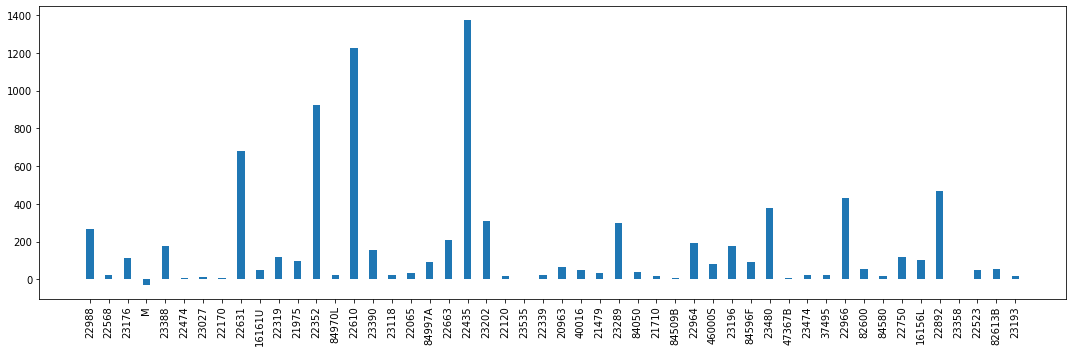

In [16]:
# Chart showig the distribution of each product for each of the available countries
# This question was not very clear for me so I will provide two solutions

# Solution one, showing products for a chosen country

# getting the data organized in the desired way
sum_per_porduct_per_country = db.transactions.aggregate([
    {"$group" : {'_id':{ 
        "product": "$StockCode",
        "country": "$Country",
      },
      "total": { "$sum" : "$Quantity" } }},
      {"$group" : { 
      '_id' :  "$_id.country",
      "products": { 
          "$push": { 
              "product":"$_id.product",
              "total_quantity":"$total"
          }
      }
   }
 }
])

# Store the data into dictionary
#I did not find a better way to deal with the results of the aggreation method as I am new to MongoDB
products_per_country_dict = {}

for product_per_country in sum_per_porduct_per_country:
    products_per_country_dict[product_per_country["_id"]] = product_per_country["products"]


country_str = "France" # Choose your country 
query_country = products_per_country_dict[country_str]

# Get the data into lists to plot them
product_codes = []
quantities = []
product_codes = [pp['product'] for pp in query_country]
quantities = [pp['total_quantity'] for pp in query_country]

# Choose a sub set of products to be able to plot quickly
start_ind = 10 # Choose your value 
end_ind = 60 # Choose your value

sub_product_codes = product_codes[start_ind:end_ind]
sub_quantities = quantities[start_ind:end_ind]
 
y_pos = np.linspace(0.5, 100, len(sub_product_codes))
    
#fig = plt.figure()
fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(15, 5))
#ax = fig.add_axes([0,0,1,1])
plt.xticks(rotation='vertical')
plt.bar(y_pos,sub_quantities)
# Create names on the x-axis
plt.xticks(y_pos, sub_product_codes)
plt.tight_layout()
plt.show()

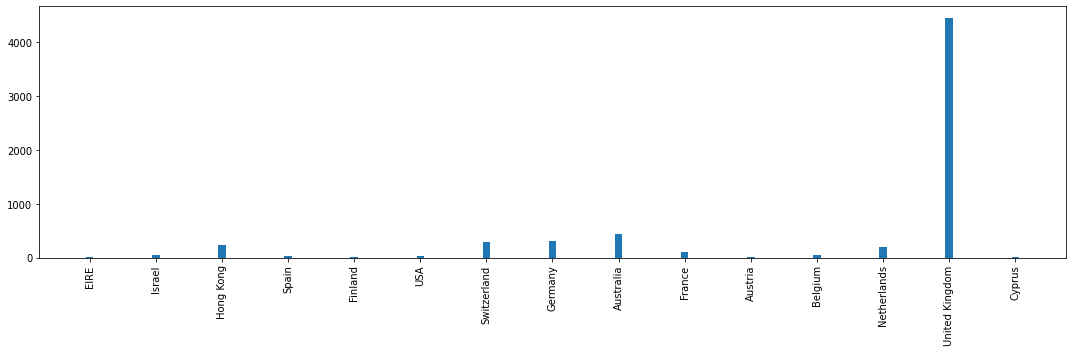

In [17]:
# Solution two, showing countries for a chosen product 

# getting the data organized in the desired way
sum_per_country_per_product = db.transactions.aggregate([
    {"$group" : {'_id':{ 
        "product": "$StockCode",
        "country": "$Country",
      },
      "total": { "$sum" : "$Quantity" } }},
      {"$group" : { 
      '_id' :  "$_id.product",
      "countries": { 
          "$push": { 
              "country":"$_id.country",
              "total_quantity":"$total"
          }
      }
   }
 }
])

# Store the data into dictionary
#I did not find a better way to deal with the results of the aggreation method as I am new to MongoDB
country_per_products_dict = {}

for country_per_product in sum_per_country_per_product:
    country_per_products_dict[country_per_product["_id"]] = country_per_product["countries"]


product_sortCode_str = "20675" # Choose your country 
query_product = country_per_products_dict[product_sortCode_str]

# Get the data into lists to plot them
countries = []
quantities = []
countries = [pp['country'] for pp in query_product]
quantities = [pp['total_quantity'] for pp in query_product]


y_pos = np.linspace(0.5, 100, len(countries))
    
#fig = plt.figure()
fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(15, 5))
#ax = fig.add_axes([0,0,1,1])
plt.xticks(rotation='vertical')
plt.bar(y_pos,quantities)
# Create names on the x-axis
plt.xticks(y_pos, countries)
plt.tight_layout()
plt.show()

In [18]:
# average unit price
avg_unit_price = db.transactions.aggregate([
    {"$group" : {'_id':"_id",
    "avg_price": { '$avg': "$UnitPrice" } }},
])

In [19]:
# Showing the results
for avg_price in avg_unit_price:
    print(" Average Price = {Price}".format(
         Price=avg_price["avg_price"]
   ))

 Average Price = 4.063889694395717


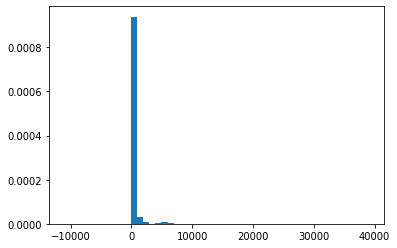

In [20]:
# Chart showing the distribution of prices
prices = db.transactions.distinct('UnitPrice')

plt.hist(prices, bins=50, density=True)
plt.show()

In [21]:
# ratio between price and quantity for each invoice
ratio_price_quantity = db.transactions.aggregate([
    
     { "$project": {
         "InvoiceNo" : "$InvoiceNo",
        "totalPrice": {"$multiply":["$Quantity", "$UnitPrice"]} , 
         "Quantity": "$Quantity"}
    }, 

     {"$group" : {'_id':"$InvoiceNo", 
                  "QuantityInvoice" : { "$sum": "$Quantity" },
                  "totalPriceInvoice" : { "$sum": "$totalPrice" }
                  }},
    { "$project": {
        "ratio": { "$cond": [ { "$eq": [ "$QuantityInvoice", 0 ] }, "N/A", {"$divide":["$totalPriceInvoice", "$QuantityInvoice"]} ] }
    } }
])

In [22]:
for ratio in ratio_price_quantity:
     print(" * InvoiceNo = {InvoiceNo}, ratio price to quantity = {ratio_price}".format(
         InvoiceNo=ratio["_id"],
         ratio_price=ratio["ratio"]
   ))

 * InvoiceNo = 538195, ratio price to quantity = 6.75
 * InvoiceNo = 561669, ratio price to quantity = 1.2028148148148148
 * InvoiceNo = 579742, ratio price to quantity = -0.0
 * InvoiceNo = 556913, ratio price to quantity = 1.8846153846153846
 * InvoiceNo = 560209, ratio price to quantity = 1.9782857142857142
 * InvoiceNo = C560317, ratio price to quantity = 5.616666666666667
 * InvoiceNo = 577514, ratio price to quantity = 2.066559139784946
 * InvoiceNo = 538935, ratio price to quantity = 2.6287323943661973
 * InvoiceNo = 547704, ratio price to quantity = 0.0
 * InvoiceNo = 552064, ratio price to quantity = 3.2861111111111114
 * InvoiceNo = 555514, ratio price to quantity = 2.472450980392157
 * InvoiceNo = 576691, ratio price to quantity = 4.95
 * InvoiceNo = 577054, ratio price to quantity = 1.075
 * InvoiceNo = 550989, ratio price to quantity = 1.6081132075471698
 * InvoiceNo = C550172, ratio price to quantity = 0.38999999999999996
 * InvoiceNo = 541698, ratio price to quantity = 1

 * InvoiceNo = 574742, ratio price to quantity = 1.25
 * InvoiceNo = 577408, ratio price to quantity = 7.3966666666666665
 * InvoiceNo = 578375, ratio price to quantity = 1.1959701492537314
 * InvoiceNo = C548576, ratio price to quantity = 24.71666666666667
 * InvoiceNo = 559929, ratio price to quantity = 0.9300738007380074
 * InvoiceNo = 568104, ratio price to quantity = 1.547446808510638
 * InvoiceNo = 554706, ratio price to quantity = 2.226923076923077
 * InvoiceNo = 551896, ratio price to quantity = 1.4013114754098361
 * InvoiceNo = 557529, ratio price to quantity = 2.505064935064935
 * InvoiceNo = 537915, ratio price to quantity = 2.1527966101694918
 * InvoiceNo = 547888, ratio price to quantity = 1.8666666666666667
 * InvoiceNo = 550004, ratio price to quantity = 2.737058823529412
 * InvoiceNo = C538105, ratio price to quantity = 8.3
 * InvoiceNo = C540378, ratio price to quantity = 1.25
 * InvoiceNo = 557642, ratio price to quantity = 5.965
 * InvoiceNo = 551323, ratio price to 

 * InvoiceNo = 559951, ratio price to quantity = 2.578333333333333
 * InvoiceNo = 550290, ratio price to quantity = 2.0381987577639755
 * InvoiceNo = 566694, ratio price to quantity = 1.2832258064516129
 * InvoiceNo = 559024, ratio price to quantity = 1.91
 * InvoiceNo = 569895, ratio price to quantity = 0.0
 * InvoiceNo = 569232, ratio price to quantity = 2.3067924528301886
 * InvoiceNo = 576841, ratio price to quantity = 3.2376470588235295
 * InvoiceNo = 547671, ratio price to quantity = 1.5214634146341461
 * InvoiceNo = 572458, ratio price to quantity = 1.3664109589041096
 * InvoiceNo = 557525, ratio price to quantity = 1.80657223796034
 * InvoiceNo = 543348, ratio price to quantity = 145.0
 * InvoiceNo = 579095, ratio price to quantity = 3.1546153846153846
 * InvoiceNo = 566772, ratio price to quantity = 1.2525198938992042
 * InvoiceNo = 543097, ratio price to quantity = 4.546771929824561
 * InvoiceNo = C549905, ratio price to quantity = 14.216666666666667
 * InvoiceNo = 564943, ra

 * InvoiceNo = 561666, ratio price to quantity = 0.0
 * InvoiceNo = 568144, ratio price to quantity = 1.2329824561403508
 * InvoiceNo = 565672, ratio price to quantity = 1.706319018404908
 * InvoiceNo = 570127, ratio price to quantity = 1.5175
 * InvoiceNo = 578031, ratio price to quantity = 4.7025
 * InvoiceNo = 560991, ratio price to quantity = 1.518890784982935
 * InvoiceNo = 562456, ratio price to quantity = 1.3224342105263158
 * InvoiceNo = 553852, ratio price to quantity = 1.2432963988919667
 * InvoiceNo = 562270, ratio price to quantity = 4.95
 * InvoiceNo = 564961, ratio price to quantity = 1.7828571428571427
 * InvoiceNo = 538594, ratio price to quantity = 0.44510204081632654
 * InvoiceNo = 558760, ratio price to quantity = 1.5648734177215189
 * InvoiceNo = 570822, ratio price to quantity = 0.0
 * InvoiceNo = 576932, ratio price to quantity = 2.356507177033493
 * InvoiceNo = 549619, ratio price to quantity = 1.3433870967741937
 * InvoiceNo = 552216, ratio price to quantity = -

 * InvoiceNo = 542149, ratio price to quantity = 0.9045833333333333
 * InvoiceNo = C560898, ratio price to quantity = 15.549999999999999
 * InvoiceNo = 546768, ratio price to quantity = 5.8476
 * InvoiceNo = 545533, ratio price to quantity = 1.3861224489795918
 * InvoiceNo = 568317, ratio price to quantity = 3.432696629213483
 * InvoiceNo = 567850, ratio price to quantity = 1.5524207492795388
 * InvoiceNo = 569250, ratio price to quantity = 1.708896797153025
 * InvoiceNo = 545685, ratio price to quantity = 1.7263013698630139
 * InvoiceNo = 573080, ratio price to quantity = 4161.06
 * InvoiceNo = 574325, ratio price to quantity = 1.7955384615384615
 * InvoiceNo = 543471, ratio price to quantity = 0.0
 * InvoiceNo = 575498, ratio price to quantity = 2.5384615384615383
 * InvoiceNo = 567613, ratio price to quantity = 1.6242218246869409
 * InvoiceNo = 574033, ratio price to quantity = 3.0816326530612246
 * InvoiceNo = 558916, ratio price to quantity = 3.2193203883495145
 * InvoiceNo = C547

 * InvoiceNo = 550339, ratio price to quantity = 3.6446236559139784
 * InvoiceNo = C576397, ratio price to quantity = 9.95
 * InvoiceNo = 553521, ratio price to quantity = 3.077891156462585
 * InvoiceNo = 565929, ratio price to quantity = 1.2509589041095892
 * InvoiceNo = C553532, ratio price to quantity = 2.1161538461538463
 * InvoiceNo = 536532, ratio price to quantity = 1.0362526997840171
 * InvoiceNo = 558756, ratio price to quantity = 3.198913043478261
 * InvoiceNo = 574490, ratio price to quantity = 1.4625000000000001
 * InvoiceNo = 578685, ratio price to quantity = 2.04
 * InvoiceNo = 565793, ratio price to quantity = 1.8500000000000003
 * InvoiceNo = C577096, ratio price to quantity = 5.95
 * InvoiceNo = 552554, ratio price to quantity = 2.1020394736842105
 * InvoiceNo = 569727, ratio price to quantity = 2.889423076923077
 * InvoiceNo = 564367, ratio price to quantity = 2.2013636363636366
 * InvoiceNo = 553496, ratio price to quantity = 6.11
 * InvoiceNo = 543920, ratio price t

 * InvoiceNo = 541510, ratio price to quantity = 3.6348214285714286
 * InvoiceNo = 546774, ratio price to quantity = 1.8831391585760517
 * InvoiceNo = 564037, ratio price to quantity = 0.7833492822966507
 * InvoiceNo = 566891, ratio price to quantity = 2.4745283018867923
 * InvoiceNo = 557526, ratio price to quantity = 1.7653846153846153
 * InvoiceNo = 571238, ratio price to quantity = 3.479444444444445
 * InvoiceNo = 573345, ratio price to quantity = 0.9382719546742209
 * InvoiceNo = 540682, ratio price to quantity = 0.4276
 * InvoiceNo = 573763, ratio price to quantity = 2.220833333333333
 * InvoiceNo = 545869, ratio price to quantity = 1.3737762237762239
 * InvoiceNo = 550495, ratio price to quantity = 2.7416216216216216
 * InvoiceNo = C545887, ratio price to quantity = 326.68
 * InvoiceNo = 551401, ratio price to quantity = 1.5
 * InvoiceNo = 575700, ratio price to quantity = 2.2275675675675677
 * InvoiceNo = 576336, ratio price to quantity = 0.0
 * InvoiceNo = 577321, ratio price 

 * InvoiceNo = 539828, ratio price to quantity = 5.95
 * InvoiceNo = C557467, ratio price to quantity = 4.15
 * InvoiceNo = C574999, ratio price to quantity = 8.25
 * InvoiceNo = 567826, ratio price to quantity = 0.8644444444444445
 * InvoiceNo = 550522, ratio price to quantity = 0.8986820083682008
 * InvoiceNo = 548212, ratio price to quantity = 2.112741573033708
 * InvoiceNo = 552829, ratio price to quantity = 2.3293
 * InvoiceNo = 553058, ratio price to quantity = 2.3334375
 * InvoiceNo = C539260, ratio price to quantity = 10.95
 * InvoiceNo = 573310, ratio price to quantity = 3.296666666666667
 * InvoiceNo = 577497, ratio price to quantity = 1.4912435233160621
 * InvoiceNo = 541420, ratio price to quantity = 2.95
 * InvoiceNo = 581419, ratio price to quantity = 0.9111486486486486
 * InvoiceNo = 556259, ratio price to quantity = 1.2739008620689656
 * InvoiceNo = 563204, ratio price to quantity = 2.704098360655738
 * InvoiceNo = 579917, ratio price to quantity = 4.15
 * InvoiceNo = 5

 * InvoiceNo = 560040, ratio price to quantity = 0.0
 * InvoiceNo = 567173, ratio price to quantity = 1.1058646616541354
 * InvoiceNo = 561334, ratio price to quantity = 2.38
 * InvoiceNo = 565741, ratio price to quantity = 2.162317073170732
 * InvoiceNo = C559417, ratio price to quantity = 4.95
 * InvoiceNo = 557662, ratio price to quantity = 1.925
 * InvoiceNo = 554301, ratio price to quantity = 1241.98
 * InvoiceNo = 574237, ratio price to quantity = 2.0002752293577983
 * InvoiceNo = C549685, ratio price to quantity = 1.95
 * InvoiceNo = C546886, ratio price to quantity = 5.75
 * InvoiceNo = 548613, ratio price to quantity = 0.42000000000000004
 * InvoiceNo = 551429, ratio price to quantity = -0.0
 * InvoiceNo = 541252, ratio price to quantity = 3.3883333333333336
 * InvoiceNo = 559861, ratio price to quantity = 1.9060638297872339
 * InvoiceNo = 562374, ratio price to quantity = 1.9141409691629958
 * InvoiceNo = 555420, ratio price to quantity = 2.046948051948052
 * InvoiceNo = 5637

 * InvoiceNo = C560043, ratio price to quantity = 0.72
 * InvoiceNo = 573157, ratio price to quantity = 1.7666666666666666
 * InvoiceNo = 573389, ratio price to quantity = 3.9500000000000006
 * InvoiceNo = 573400, ratio price to quantity = 4.216666666666667
 * InvoiceNo = 557069, ratio price to quantity = 1.8898888888888887
 * InvoiceNo = 578054, ratio price to quantity = 2.577405857740586
 * InvoiceNo = 564760, ratio price to quantity = 4.046107954545454
 * InvoiceNo = 569856, ratio price to quantity = 2.4077777777777776
 * InvoiceNo = 556903, ratio price to quantity = 3.2057777777777776
 * InvoiceNo = C579776, ratio price to quantity = 7.5
 * InvoiceNo = 580124, ratio price to quantity = 2.0566477272727273
 * InvoiceNo = 551667, ratio price to quantity = 0.0
 * InvoiceNo = 544195, ratio price to quantity = 1.045890410958904
 * InvoiceNo = C537644, ratio price to quantity = 13474.79
 * InvoiceNo = 552441, ratio price to quantity = 1.935542168674699
 * InvoiceNo = C562515, ratio price 

 * InvoiceNo = 542389, ratio price to quantity = 1.5331932773109245
 * InvoiceNo = 554698, ratio price to quantity = 1.514321608040201
 * InvoiceNo = 554485, ratio price to quantity = 12.483333333333334
 * InvoiceNo = 544295, ratio price to quantity = 0.9100995024875621
 * InvoiceNo = 569933, ratio price to quantity = 0.0
 * InvoiceNo = 580588, ratio price to quantity = 0.0
 * InvoiceNo = 550950, ratio price to quantity = 0.0
 * InvoiceNo = 557221, ratio price to quantity = 1.373705882352941
 * InvoiceNo = 537789, ratio price to quantity = 2.9131775700934583
 * InvoiceNo = 557430, ratio price to quantity = 3.75
 * InvoiceNo = 557858, ratio price to quantity = 1.0819377162629757
 * InvoiceNo = 552244, ratio price to quantity = 1.7582352941176471
 * InvoiceNo = 561894, ratio price to quantity = 1.0297291666666666
 * InvoiceNo = 560974, ratio price to quantity = 1.8481818181818181
 * InvoiceNo = 577542, ratio price to quantity = 1.3834042553191488
 * InvoiceNo = 553932, ratio price to qua

 * InvoiceNo = 539011, ratio price to quantity = 0.5093939393939395
 * InvoiceNo = 563441, ratio price to quantity = 2.8330188679245283
 * InvoiceNo = 571937, ratio price to quantity = 0.6401030927835051
 * InvoiceNo = 574899, ratio price to quantity = 2.7285714285714286
 * InvoiceNo = 578058, ratio price to quantity = 0.74484375
 * InvoiceNo = 581143, ratio price to quantity = 1.2625
 * InvoiceNo = C560832, ratio price to quantity = 4.95
 * InvoiceNo = 543243, ratio price to quantity = 2.992372881355932
 * InvoiceNo = 547714, ratio price to quantity = 1.6944444444444444
 * InvoiceNo = 565588, ratio price to quantity = 1.2972727272727274
 * InvoiceNo = 544452, ratio price to quantity = 1.6152727272727274
 * InvoiceNo = 546757, ratio price to quantity = 1.7425925925925927
 * InvoiceNo = 547082, ratio price to quantity = 5.529999999999999
 * InvoiceNo = 578993, ratio price to quantity = 1.3453846153846154
 * InvoiceNo = 544065, ratio price to quantity = 2.5234615384615386
 * InvoiceNo = 

 * InvoiceNo = 573308, ratio price to quantity = 6.81
 * InvoiceNo = 540168, ratio price to quantity = 1.8628451882845187
 * InvoiceNo = 559460, ratio price to quantity = 1.2857264957264958
 * InvoiceNo = 544108, ratio price to quantity = 2.7241258741258743
 * InvoiceNo = 554275, ratio price to quantity = 1.6908128078817735
 * InvoiceNo = 537607, ratio price to quantity = 2.1106756756756755
 * InvoiceNo = 541676, ratio price to quantity = 1.5113390313390314
 * InvoiceNo = C554558, ratio price to quantity = 1.25
 * InvoiceNo = C543621, ratio price to quantity = 7.183333333333333
 * InvoiceNo = 547593, ratio price to quantity = -0.0
 * InvoiceNo = 555005, ratio price to quantity = 0.8818064516129033
 * InvoiceNo = 537631, ratio price to quantity = 1.45
 * InvoiceNo = 550815, ratio price to quantity = 0.0
 * InvoiceNo = 551721, ratio price to quantity = 3.039473684210526
 * InvoiceNo = 558247, ratio price to quantity = 4.208823529411765
 * InvoiceNo = 563743, ratio price to quantity = 2.3

 * InvoiceNo = 561242, ratio price to quantity = 1.1283511269276394
 * InvoiceNo = 537247, ratio price to quantity = 1.165
 * InvoiceNo = 564726, ratio price to quantity = 1.0447404844290658
 * InvoiceNo = C567947, ratio price to quantity = 2.23
 * InvoiceNo = 564484, ratio price to quantity = 1.6159183673469388
 * InvoiceNo = 569574, ratio price to quantity = 1.6196414342629482
 * InvoiceNo = C572532, ratio price to quantity = 4.25
 * InvoiceNo = 569468, ratio price to quantity = 1.5141136363636365
 * InvoiceNo = 575843, ratio price to quantity = 1.2683064516129032
 * InvoiceNo = 575987, ratio price to quantity = 2.485
 * InvoiceNo = 545645, ratio price to quantity = 5.8500000000000005
 * InvoiceNo = 575164, ratio price to quantity = 2.40875
 * InvoiceNo = 576568, ratio price to quantity = 2.055576923076923
 * InvoiceNo = 571942, ratio price to quantity = 1.5615714285714286
 * InvoiceNo = C539574, ratio price to quantity = 6.449999999999999
 * InvoiceNo = C557224, ratio price to quant

 * InvoiceNo = 545550, ratio price to quantity = 0.7314778325123154
 * InvoiceNo = 568169, ratio price to quantity = 0.8970175438596492
 * InvoiceNo = 571279, ratio price to quantity = 2.205030674846626
 * InvoiceNo = 565674, ratio price to quantity = 3.0308108108108107
 * InvoiceNo = 571352, ratio price to quantity = 5.001515151515151
 * InvoiceNo = 572765, ratio price to quantity = 3.3499999999999996
 * InvoiceNo = 574960, ratio price to quantity = 2.4817391304347827
 * InvoiceNo = 540844, ratio price to quantity = 1.881578947368421
 * InvoiceNo = 548901, ratio price to quantity = 1.47
 * InvoiceNo = 554684, ratio price to quantity = 2.421666666666667
 * InvoiceNo = 540043, ratio price to quantity = 3.5385714285714287
 * InvoiceNo = 566033, ratio price to quantity = 1.1926960784313725
 * InvoiceNo = 567300, ratio price to quantity = 2.827135416666667
 * InvoiceNo = 580482, ratio price to quantity = 2.0479126213592234
 * InvoiceNo = 569855, ratio price to quantity = -0.0
 * InvoiceNo 

 * InvoiceNo = 555592, ratio price to quantity = 1.3345454545454545
 * InvoiceNo = 580144, ratio price to quantity = 2.1105882352941174
 * InvoiceNo = 580024, ratio price to quantity = 0.9743523316062177
 * InvoiceNo = C572491, ratio price to quantity = 3.483333333333333
 * InvoiceNo = 540595, ratio price to quantity = 0.5066976744186047
 * InvoiceNo = 545553, ratio price to quantity = 0.0
 * InvoiceNo = 552221, ratio price to quantity = -0.0
 * InvoiceNo = 549342, ratio price to quantity = -0.0
 * InvoiceNo = 576172, ratio price to quantity = 3.0258035714285714
 * InvoiceNo = 580732, ratio price to quantity = 2.1937499999999996
 * InvoiceNo = C538755, ratio price to quantity = 12.75
 * InvoiceNo = 552493, ratio price to quantity = 3.8144505494505494
 * InvoiceNo = 545084, ratio price to quantity = 1.6367407407407408
 * InvoiceNo = 560791, ratio price to quantity = 0.8782706766917293
 * InvoiceNo = 556084, ratio price to quantity = 2.5961538461538463
 * InvoiceNo = 557497, ratio price 

 * InvoiceNo = 556118, ratio price to quantity = 8.763157894736842
 * InvoiceNo = 549749, ratio price to quantity = 1.6427966101694915
 * InvoiceNo = 564202, ratio price to quantity = 2.6136363636363638
 * InvoiceNo = 567313, ratio price to quantity = 2.3404761904761906
 * InvoiceNo = C566578, ratio price to quantity = 92.93
 * InvoiceNo = 550132, ratio price to quantity = 1.769527559055118
 * InvoiceNo = 541495, ratio price to quantity = 7.1520370370370365
 * InvoiceNo = 562053, ratio price to quantity = 0.333943161634103
 * InvoiceNo = C553531, ratio price to quantity = 41.354285714285716
 * InvoiceNo = 573979, ratio price to quantity = 0.0
 * InvoiceNo = 551439, ratio price to quantity = 3.2129411764705877
 * InvoiceNo = 579733, ratio price to quantity = -0.0
 * InvoiceNo = 550781, ratio price to quantity = 2.1144036697247706
 * InvoiceNo = 552550, ratio price to quantity = 1.5510337972166999
 * InvoiceNo = 563465, ratio price to quantity = 2.8000000000000003
 * InvoiceNo = 553997, 

 * InvoiceNo = 548978, ratio price to quantity = 1.996055979643766
 * InvoiceNo = C560899, ratio price to quantity = 1.25
 * InvoiceNo = 550503, ratio price to quantity = 2.022207792207792
 * InvoiceNo = 566054, ratio price to quantity = 1.6464
 * InvoiceNo = 573275, ratio price to quantity = 1.9592413793103451
 * InvoiceNo = 569910, ratio price to quantity = 1.8907894736842106
 * InvoiceNo = 574670, ratio price to quantity = 2.231603053435115
 * InvoiceNo = 543164, ratio price to quantity = 1.0729299363057323
 * InvoiceNo = 574870, ratio price to quantity = 1.052896551724138
 * InvoiceNo = 576880, ratio price to quantity = 2.369054054054054
 * InvoiceNo = 556043, ratio price to quantity = 3.3415068493150684
 * InvoiceNo = C544436, ratio price to quantity = 1.875
 * InvoiceNo = C570658, ratio price to quantity = 1.25
 * InvoiceNo = 563843, ratio price to quantity = 1.9112280701754385
 * InvoiceNo = 536805, ratio price to quantity = 1.05875
 * InvoiceNo = C573864, ratio price to quantit

 * InvoiceNo = C538650, ratio price to quantity = 5.383333333333333
 * InvoiceNo = 548012, ratio price to quantity = 2.691186440677966
 * InvoiceNo = 559602, ratio price to quantity = 0.0
 * InvoiceNo = C561612, ratio price to quantity = 1.25
 * InvoiceNo = 555201, ratio price to quantity = 1.0241237113402062
 * InvoiceNo = C577353, ratio price to quantity = 4.0
 * InvoiceNo = 562351, ratio price to quantity = 1.32
 * InvoiceNo = 581166, ratio price to quantity = 2.458515625
 * InvoiceNo = 541963, ratio price to quantity = 5.237878787878787
 * InvoiceNo = 556927, ratio price to quantity = 1.4673959121877367
 * InvoiceNo = 553689, ratio price to quantity = 3.63
 * InvoiceNo = 543113, ratio price to quantity = 2.1748815165876776
 * InvoiceNo = C559947, ratio price to quantity = 1.7611764705882351
 * InvoiceNo = 570126, ratio price to quantity = 2.7163999999999997
 * InvoiceNo = 570429, ratio price to quantity = 2.064639175257732
 * InvoiceNo = 547108, ratio price to quantity = 2.15018867

 * InvoiceNo = 578783, ratio price to quantity = 0.9582368421052632
 * InvoiceNo = 580281, ratio price to quantity = 2.453827160493827
 * InvoiceNo = 556052, ratio price to quantity = 1.45
 * InvoiceNo = 563920, ratio price to quantity = 1.8958577405857742
 * InvoiceNo = 579170, ratio price to quantity = 2.992698412698413
 * InvoiceNo = 538870, ratio price to quantity = 0.686
 * InvoiceNo = 541971, ratio price to quantity = 4.32815
 * InvoiceNo = 552960, ratio price to quantity = 1.5606194690265487
 * InvoiceNo = 559794, ratio price to quantity = 1.101432098765432
 * InvoiceNo = 538011, ratio price to quantity = 1.3979347826086959
 * InvoiceNo = 548714, ratio price to quantity = 1.7700757575757575
 * InvoiceNo = 540900, ratio price to quantity = 2.584020618556701
 * InvoiceNo = 563237, ratio price to quantity = 0.7561325966850828
 * InvoiceNo = 571221, ratio price to quantity = 1.7760106382978722
 * InvoiceNo = C579752, ratio price to quantity = 3.1799999999999997
 * InvoiceNo = 554143

 * InvoiceNo = 565192, ratio price to quantity = 1.65
 * InvoiceNo = 569085, ratio price to quantity = 1.06
 * InvoiceNo = 569242, ratio price to quantity = 2.2094871794871795
 * InvoiceNo = 552285, ratio price to quantity = 1.5595555555555554
 * InvoiceNo = 571486, ratio price to quantity = 0.7826766595289079
 * InvoiceNo = 539005, ratio price to quantity = 0.85
 * InvoiceNo = 577954, ratio price to quantity = 0.0
 * InvoiceNo = C579092, ratio price to quantity = 0.1593577981651376
 * InvoiceNo = 568079, ratio price to quantity = -0.0
 * InvoiceNo = 547041, ratio price to quantity = 1.5384615384615385
 * InvoiceNo = 550963, ratio price to quantity = 1.692857142857143
 * InvoiceNo = 553406, ratio price to quantity = 1.55
 * InvoiceNo = 570270, ratio price to quantity = 6.216666666666667
 * InvoiceNo = 538043, ratio price to quantity = -0.0
 * InvoiceNo = 541505, ratio price to quantity = 15.0
 * InvoiceNo = C572428, ratio price to quantity = 464.9
 * InvoiceNo = 563247, ratio price to 

 * InvoiceNo = 570726, ratio price to quantity = 1.546330275229358
 * InvoiceNo = 573505, ratio price to quantity = -0.0
 * InvoiceNo = 551617, ratio price to quantity = 2.55
 * InvoiceNo = 570212, ratio price to quantity = 0.8964444444444445
 * InvoiceNo = 564642, ratio price to quantity = 0.41626237623762374
 * InvoiceNo = 561085, ratio price to quantity = 1.6869872958257712
 * InvoiceNo = 577944, ratio price to quantity = 0.0
 * InvoiceNo = 553217, ratio price to quantity = 8.5
 * InvoiceNo = 573905, ratio price to quantity = 4.96125
 * InvoiceNo = 573990, ratio price to quantity = 0.0
 * InvoiceNo = 555410, ratio price to quantity = 1.9115384615384614
 * InvoiceNo = 550016, ratio price to quantity = 1.7225862068965518
 * InvoiceNo = 576212, ratio price to quantity = 1.1326409017713366
 * InvoiceNo = C542693, ratio price to quantity = 0.65
 * InvoiceNo = C576223, ratio price to quantity = 6.225
 * InvoiceNo = 550291, ratio price to quantity = 3.606521739130435
 * InvoiceNo = 560180,

 * InvoiceNo = 575720, ratio price to quantity = -0.0
 * InvoiceNo = 537809, ratio price to quantity = 4.55
 * InvoiceNo = 540693, ratio price to quantity = 0.0
 * InvoiceNo = C536622, ratio price to quantity = 8.5
 * InvoiceNo = 558295, ratio price to quantity = 1.3084313725490195
 * InvoiceNo = 542911, ratio price to quantity = 2.038
 * InvoiceNo = 553351, ratio price to quantity = 1.7710227272727272
 * InvoiceNo = 538826, ratio price to quantity = 1.7348091603053435
 * InvoiceNo = C564900, ratio price to quantity = 3.75
 * InvoiceNo = 575944, ratio price to quantity = 1.5083333333333333
 * InvoiceNo = 560443, ratio price to quantity = 0.9998019801980198
 * InvoiceNo = 555896, ratio price to quantity = 1.6320550161812297
 * InvoiceNo = C567349, ratio price to quantity = 5.75
 * InvoiceNo = 540489, ratio price to quantity = 2.813316582914573
 * InvoiceNo = C575052, ratio price to quantity = 1.65
 * InvoiceNo = 551572, ratio price to quantity = -0.0
 * InvoiceNo = 542563, ratio price t

 * InvoiceNo = C541897, ratio price to quantity = 5.95
 * InvoiceNo = 573139, ratio price to quantity = 0.5667469879518072
 * InvoiceNo = 551907, ratio price to quantity = 0.7848993288590604
 * InvoiceNo = 536620, ratio price to quantity = 0.6548582995951417
 * InvoiceNo = 560300, ratio price to quantity = 0.6659400998336107
 * InvoiceNo = 566822, ratio price to quantity = 1.7717127071823204
 * InvoiceNo = C569945, ratio price to quantity = 3.716666666666667
 * InvoiceNo = 574046, ratio price to quantity = 2.9268085106382977
 * InvoiceNo = 547076, ratio price to quantity = 1.5765017667844523
 * InvoiceNo = 557223, ratio price to quantity = 2.179425287356322
 * InvoiceNo = 562392, ratio price to quantity = 2.4301020408163265
 * InvoiceNo = 579510, ratio price to quantity = 1.6338202247191014
 * InvoiceNo = 561026, ratio price to quantity = 1.010225988700565
 * InvoiceNo = 580434, ratio price to quantity = 2.27225
 * InvoiceNo = 580982, ratio price to quantity = 0.9703097345132743
 * Inv

 * InvoiceNo = 556510, ratio price to quantity = 1.9234660421545668
 * InvoiceNo = 564844, ratio price to quantity = 3.82
 * InvoiceNo = 581395, ratio price to quantity = 3.517714285714286
 * InvoiceNo = 578113, ratio price to quantity = 0.55
 * InvoiceNo = C536734, ratio price to quantity = 4.99
 * InvoiceNo = C543175, ratio price to quantity = 10.271428571428572
 * InvoiceNo = 564743, ratio price to quantity = 2.5154
 * InvoiceNo = 557103, ratio price to quantity = 2.216862745098039
 * InvoiceNo = 546878, ratio price to quantity = 4.0
 * InvoiceNo = 554051, ratio price to quantity = 4.95
 * InvoiceNo = 554637, ratio price to quantity = 1.876909090909091
 * InvoiceNo = 558755, ratio price to quantity = 1.3413043478260869
 * InvoiceNo = 557259, ratio price to quantity = 1.9585714285714286
 * InvoiceNo = 562385, ratio price to quantity = -0.0
 * InvoiceNo = 555578, ratio price to quantity = 1.7281818181818183
 * InvoiceNo = C561623, ratio price to quantity = 2.25
 * InvoiceNo = 563597, 

 * InvoiceNo = 569936, ratio price to quantity = 1.5035294117647058
 * InvoiceNo = 538263, ratio price to quantity = 1.7281818181818183
 * InvoiceNo = 550826, ratio price to quantity = 1.3559999999999999
 * InvoiceNo = 563890, ratio price to quantity = 1.205142857142857
 * InvoiceNo = 539858, ratio price to quantity = 3.6357142857142852
 * InvoiceNo = C551526, ratio price to quantity = 1.95
 * InvoiceNo = 570252, ratio price to quantity = 2.350924369747899
 * InvoiceNo = 574317, ratio price to quantity = 0.4822916666666666
 * InvoiceNo = 575368, ratio price to quantity = 2.2701818181818183
 * InvoiceNo = 551339, ratio price to quantity = 4.620989583333333
 * InvoiceNo = 556074, ratio price to quantity = -0.0
 * InvoiceNo = 564756, ratio price to quantity = 3.0603800475059377
 * InvoiceNo = 565199, ratio price to quantity = 2.791801801801802
 * InvoiceNo = C574658, ratio price to quantity = 1.254
 * InvoiceNo = 538801, ratio price to quantity = 0.8801562500000001
 * InvoiceNo = 544649, 

 * InvoiceNo = 560185, ratio price to quantity = 0.7290322580645161
 * InvoiceNo = 551188, ratio price to quantity = 2.6491525423728817
 * InvoiceNo = 536988, ratio price to quantity = 2.5439000000000003
 * InvoiceNo = C549019, ratio price to quantity = 3.0785714285714287
 * InvoiceNo = C551948, ratio price to quantity = 3.311818181818182
 * InvoiceNo = 548746, ratio price to quantity = 1.25
 * InvoiceNo = C538341, ratio price to quantity = 3.5289440993788825
 * InvoiceNo = 553017, ratio price to quantity = 1.9383601286173635
 * InvoiceNo = 555280, ratio price to quantity = 1.7327407407407407
 * InvoiceNo = 552850, ratio price to quantity = 2.9500000000000006
 * InvoiceNo = 563438, ratio price to quantity = 0.99
 * InvoiceNo = 543293, ratio price to quantity = 1.767469879518072
 * InvoiceNo = 544169, ratio price to quantity = 2.702093023255814
 * InvoiceNo = 542879, ratio price to quantity = -0.0
 * InvoiceNo = 555927, ratio price to quantity = 0.3333333333333333
 * InvoiceNo = C568575

 * InvoiceNo = 570118, ratio price to quantity = 3.216666666666667
 * InvoiceNo = 543543, ratio price to quantity = 1.8184070796460177
 * InvoiceNo = 541238, ratio price to quantity = 3.314406779661017
 * InvoiceNo = C574825, ratio price to quantity = 3.326923076923077
 * InvoiceNo = 562537, ratio price to quantity = 1.8331353919239906
 * InvoiceNo = 571315, ratio price to quantity = 2.6004347826086955
 * InvoiceNo = C550709, ratio price to quantity = 1.42
 * InvoiceNo = 543735, ratio price to quantity = 2.256842105263158
 * InvoiceNo = 559070, ratio price to quantity = 1.474
 * InvoiceNo = 552727, ratio price to quantity = 1.9597260273972603
 * InvoiceNo = 555149, ratio price to quantity = 4.3281481481481485
 * InvoiceNo = 567868, ratio price to quantity = 5.334054054054055
 * InvoiceNo = 567178, ratio price to quantity = 7.827647058823529
 * InvoiceNo = 559733, ratio price to quantity = 0.9719182389937107
 * InvoiceNo = 541488, ratio price to quantity = 1.5067567567567568
 * InvoiceN

 * InvoiceNo = 537128, ratio price to quantity = 1.5684444444444445
 * InvoiceNo = 537254, ratio price to quantity = 1.8223333333333334
 * InvoiceNo = 545279, ratio price to quantity = 2.311320754716981
 * InvoiceNo = 545574, ratio price to quantity = 1.53375
 * InvoiceNo = 558379, ratio price to quantity = -0.0
 * InvoiceNo = 578086, ratio price to quantity = 1.8351546391752576
 * InvoiceNo = 557604, ratio price to quantity = 2.41070110701107
 * InvoiceNo = 569884, ratio price to quantity = -0.0
 * InvoiceNo = C570290, ratio price to quantity = 2.350924369747899
 * InvoiceNo = 550327, ratio price to quantity = 1.611373134328358
 * InvoiceNo = C570962, ratio price to quantity = 1.25
 * InvoiceNo = 574756, ratio price to quantity = 2.3921875
 * InvoiceNo = 579261, ratio price to quantity = 1.0972027972027973
 * InvoiceNo = 543199, ratio price to quantity = 1.653050847457627
 * InvoiceNo = 561820, ratio price to quantity = 4.14010781671159
 * InvoiceNo = 580138, ratio price to quantity =

 * InvoiceNo = 552217, ratio price to quantity = 2.5563865546218487
 * InvoiceNo = 538671, ratio price to quantity = 3.2349557522123895
 * InvoiceNo = 567901, ratio price to quantity = 3.760582278481013
 * InvoiceNo = 576844, ratio price to quantity = 1.4049370277078086
 * InvoiceNo = C563592, ratio price to quantity = 9.6
 * InvoiceNo = 542408, ratio price to quantity = 1.1428862973760934
 * InvoiceNo = 570807, ratio price to quantity = 2.3648214285714286
 * InvoiceNo = 560097, ratio price to quantity = 1.325703125
 * InvoiceNo = 580113, ratio price to quantity = 2.8167999999999997
 * InvoiceNo = 551847, ratio price to quantity = 4.95
 * InvoiceNo = 553413, ratio price to quantity = -0.0
 * InvoiceNo = 546318, ratio price to quantity = 2.55
 * InvoiceNo = 542148, ratio price to quantity = 1.1204444444444446
 * InvoiceNo = 546013, ratio price to quantity = 1.4424848484848485
 * InvoiceNo = C550647, ratio price to quantity = 3.7125
 * InvoiceNo = 546301, ratio price to quantity = 1.4118

 * InvoiceNo = 577797, ratio price to quantity = 1.25
 * InvoiceNo = 541522, ratio price to quantity = 3.2372549019607844
 * InvoiceNo = 551996, ratio price to quantity = 1.8346875
 * InvoiceNo = 555422, ratio price to quantity = 6.25
 * InvoiceNo = C562884, ratio price to quantity = 3.25
 * InvoiceNo = 565723, ratio price to quantity = 1.9101265822784814
 * InvoiceNo = 555010, ratio price to quantity = 1.48
 * InvoiceNo = C575004, ratio price to quantity = 8.25
 * InvoiceNo = 557114, ratio price to quantity = 1.1
 * InvoiceNo = C575666, ratio price to quantity = 1.25
 * InvoiceNo = 578678, ratio price to quantity = 1.1597994987468672
 * InvoiceNo = 544455, ratio price to quantity = 2.0455208333333332
 * InvoiceNo = C538372, ratio price to quantity = 1.741666666666667
 * InvoiceNo = 546387, ratio price to quantity = 2.1373134328358208
 * InvoiceNo = 556886, ratio price to quantity = 1.4420192307692308
 * InvoiceNo = 542123, ratio price to quantity = 3.265384615384615
 * InvoiceNo = 560

 * InvoiceNo = C574322, ratio price to quantity = 10.949999999999998
 * InvoiceNo = 549317, ratio price to quantity = 3.701908396946565
 * InvoiceNo = 540997, ratio price to quantity = 0.8441935483870967
 * InvoiceNo = C574850, ratio price to quantity = 4.15
 * InvoiceNo = 551294, ratio price to quantity = 1.6453191489361703
 * InvoiceNo = 575512, ratio price to quantity = 1.5870356234096694
 * InvoiceNo = 575914, ratio price to quantity = 1.367594936708861
 * InvoiceNo = 578846, ratio price to quantity = 1.2218394648829431
 * InvoiceNo = 558070, ratio price to quantity = 0.85
 * InvoiceNo = 572090, ratio price to quantity = 0.8963481228668941
 * InvoiceNo = 561195, ratio price to quantity = 0.9860664335664335
 * InvoiceNo = 561593, ratio price to quantity = 2.8000000000000003
 * InvoiceNo = 579184, ratio price to quantity = 3.238709677419355
 * InvoiceNo = 579497, ratio price to quantity = 1.552325581395349
 * InvoiceNo = C571499, ratio price to quantity = 3.507296222664016
 * Invoice

 * InvoiceNo = 538636, ratio price to quantity = 2.487279411764706
 * InvoiceNo = 543332, ratio price to quantity = 1.8645454545454545
 * InvoiceNo = 557397, ratio price to quantity = 1.8079452054794518
 * InvoiceNo = C563224, ratio price to quantity = 4.95
 * InvoiceNo = 580661, ratio price to quantity = 2.050754716981132
 * InvoiceNo = 572225, ratio price to quantity = 1.3333640552995392
 * InvoiceNo = 578812, ratio price to quantity = 1.9603351955307262
 * InvoiceNo = 581426, ratio price to quantity = 2.1850961538461537
 * InvoiceNo = 539303, ratio price to quantity = 2.1626732673267326
 * InvoiceNo = 546550, ratio price to quantity = 6.35
 * InvoiceNo = 566428, ratio price to quantity = 0.7338862559241706
 * InvoiceNo = 547374, ratio price to quantity = 1.9876223776223778
 * InvoiceNo = 564632, ratio price to quantity = 2.3725125628140704
 * InvoiceNo = 565087, ratio price to quantity = 6.869
 * InvoiceNo = 549947, ratio price to quantity = 1.4381528662420382
 * InvoiceNo = 536398,

 * InvoiceNo = 581457, ratio price to quantity = 4.3174188861985465
 * InvoiceNo = 556267, ratio price to quantity = 0.3563420693081605
 * InvoiceNo = 564573, ratio price to quantity = 2.2622448979591834
 * InvoiceNo = 541423, ratio price to quantity = 2.6324227642276425
 * InvoiceNo = 565788, ratio price to quantity = 1.118607594936709
 * InvoiceNo = 551447, ratio price to quantity = -0.0
 * InvoiceNo = 538706, ratio price to quantity = 0.796938775510204
 * InvoiceNo = 547817, ratio price to quantity = 1.9499999999999997
 * InvoiceNo = 548736, ratio price to quantity = 1.06
 * InvoiceNo = C544397, ratio price to quantity = 5.2
 * InvoiceNo = 541794, ratio price to quantity = 2.474107142857143
 * InvoiceNo = 558064, ratio price to quantity = 0.7899999999999999
 * InvoiceNo = 573000, ratio price to quantity = 1.4986153846153845
 * InvoiceNo = 576854, ratio price to quantity = 1.1766666666666667
 * InvoiceNo = C541650, ratio price to quantity = 544.4
 * InvoiceNo = 579125, ratio price to

 * InvoiceNo = C543834, ratio price to quantity = 0.42
 * InvoiceNo = 541236, ratio price to quantity = 3.35
 * InvoiceNo = 577472, ratio price to quantity = 2.1732231404958675
 * InvoiceNo = 558933, ratio price to quantity = 4.327611940298508
 * InvoiceNo = C555879, ratio price to quantity = 4.95
 * InvoiceNo = 559905, ratio price to quantity = 1.3523008849557523
 * InvoiceNo = 559422, ratio price to quantity = 2.0784671532846715
 * InvoiceNo = 567153, ratio price to quantity = 2.132314049586777
 * InvoiceNo = 536594, ratio price to quantity = 2.338235294117647
 * InvoiceNo = 540247, ratio price to quantity = 2.9967142857142854
 * InvoiceNo = 549332, ratio price to quantity = -0.0
 * InvoiceNo = C555006, ratio price to quantity = 1.45
 * InvoiceNo = 549551, ratio price to quantity = 2.1475545851528386
 * InvoiceNo = 549961, ratio price to quantity = 12.75
 * InvoiceNo = C559663, ratio price to quantity = 5.2375
 * InvoiceNo = C570692, ratio price to quantity = 4.15
 * InvoiceNo = 5472

 * InvoiceNo = C539066, ratio price to quantity = 7.699999999999999
 * InvoiceNo = 558562, ratio price to quantity = 1.2805785123966942
 * InvoiceNo = 572104, ratio price to quantity = 9.37
 * InvoiceNo = C566672, ratio price to quantity = 1.25
 * InvoiceNo = 537361, ratio price to quantity = 0.0
 * InvoiceNo = 551878, ratio price to quantity = 3.99
 * InvoiceNo = 580772, ratio price to quantity = 2.4699999999999998
 * InvoiceNo = 542275, ratio price to quantity = 1.4633333333333334
 * InvoiceNo = 560247, ratio price to quantity = 3.2911764705882356
 * InvoiceNo = 559162, ratio price to quantity = 2.369458272327965
 * InvoiceNo = 540466, ratio price to quantity = 4.25
 * InvoiceNo = 541596, ratio price to quantity = 0.9600125156445558
 * InvoiceNo = 551418, ratio price to quantity = 0.6972049689440993
 * InvoiceNo = 556104, ratio price to quantity = 1.3528169014084506
 * InvoiceNo = 570649, ratio price to quantity = 1.9303750000000002
 * InvoiceNo = 574967, ratio price to quantity = 4.

 * InvoiceNo = 538041, ratio price to quantity = 0.0
 * InvoiceNo = 551383, ratio price to quantity = 2.2622641509433965
 * InvoiceNo = 559157, ratio price to quantity = 1.838502994011976
 * InvoiceNo = 558199, ratio price to quantity = 3.2659999999999996
 * InvoiceNo = 566326, ratio price to quantity = 3.552077922077922
 * InvoiceNo = C570573, ratio price to quantity = 0.29
 * InvoiceNo = 537441, ratio price to quantity = 2.109375
 * InvoiceNo = 561668, ratio price to quantity = -0.0
 * InvoiceNo = 540040, ratio price to quantity = 1.868805460750853
 * InvoiceNo = 566816, ratio price to quantity = 2.243301886792453
 * InvoiceNo = 552202, ratio price to quantity = 3.9488095238095235
 * InvoiceNo = 575899, ratio price to quantity = 1.8842931937172773
 * InvoiceNo = 576395, ratio price to quantity = 5.1000000000000005
 * InvoiceNo = 542093, ratio price to quantity = 2.551530612244898
 * InvoiceNo = 548983, ratio price to quantity = 2.5475555555555554
 * InvoiceNo = 574478, ratio price to

 * InvoiceNo = 571326, ratio price to quantity = 339.02
 * InvoiceNo = 573368, ratio price to quantity = 2.985
 * InvoiceNo = 541683, ratio price to quantity = 0.878936170212766
 * InvoiceNo = 564141, ratio price to quantity = 2.466964285714286
 * InvoiceNo = 579012, ratio price to quantity = 3.748409090909091
 * InvoiceNo = 552211, ratio price to quantity = 1.0985714285714285
 * InvoiceNo = 553379, ratio price to quantity = 2.048666666666667
 * InvoiceNo = C537417, ratio price to quantity = 4.25
 * InvoiceNo = 549543, ratio price to quantity = 1.9362745098039216
 * InvoiceNo = 552292, ratio price to quantity = 1.7363636363636366
 * InvoiceNo = 556682, ratio price to quantity = 1.035076923076923
 * InvoiceNo = 561624, ratio price to quantity = 0.2318181818181818
 * InvoiceNo = 540184, ratio price to quantity = 6.627777777777777
 * InvoiceNo = 552893, ratio price to quantity = 2.3462886597938146
 * InvoiceNo = 572300, ratio price to quantity = 2.856530612244898
 * InvoiceNo = 546329, ra

 * InvoiceNo = 574830, ratio price to quantity = 0.49083544303797466
 * InvoiceNo = 547348, ratio price to quantity = 0.0
 * InvoiceNo = 556065, ratio price to quantity = 1.9770270270270272
 * InvoiceNo = 568194, ratio price to quantity = 1.5573983739837398
 * InvoiceNo = 562088, ratio price to quantity = 1.0600000000000003
 * InvoiceNo = 579740, ratio price to quantity = 2.4669230769230768
 * InvoiceNo = 557601, ratio price to quantity = 3.8833333333333337
 * InvoiceNo = 544426, ratio price to quantity = 8.5
 * InvoiceNo = C538717, ratio price to quantity = 2.9500000000000006
 * InvoiceNo = 564640, ratio price to quantity = 1.1482840236686391
 * InvoiceNo = 580292, ratio price to quantity = 2.4311009174311926
 * InvoiceNo = C572450, ratio price to quantity = 139.075
 * InvoiceNo = 547805, ratio price to quantity = 2.443556701030928
 * InvoiceNo = 544168, ratio price to quantity = 2.183333333333333
 * InvoiceNo = 577091, ratio price to quantity = 3.0686046511627905
 * InvoiceNo = 54973

 * InvoiceNo = 548372, ratio price to quantity = 3.7564516129032257
 * InvoiceNo = 552977, ratio price to quantity = 1.906260162601626
 * InvoiceNo = 555322, ratio price to quantity = 6.425777777777777
 * InvoiceNo = 570457, ratio price to quantity = 5.15
 * InvoiceNo = 554263, ratio price to quantity = 0.65
 * InvoiceNo = C571507, ratio price to quantity = 0.9364864864864865
 * InvoiceNo = 551957, ratio price to quantity = 4.59909090909091
 * InvoiceNo = 569386, ratio price to quantity = 6.410526315789474
 * InvoiceNo = 540819, ratio price to quantity = 7.95
 * InvoiceNo = C571893, ratio price to quantity = 2.5957894736842104
 * InvoiceNo = C579878, ratio price to quantity = 2.9717073170731707
 * InvoiceNo = 580064, ratio price to quantity = 1.3161855670103093
 * InvoiceNo = C544318, ratio price to quantity = 2.1
 * InvoiceNo = 565287, ratio price to quantity = 1.8984662576687117
 * InvoiceNo = C540347, ratio price to quantity = 8.5
 * InvoiceNo = 554132, ratio price to quantity = 2.4

 * InvoiceNo = 546303, ratio price to quantity = 8.62
 * InvoiceNo = C560733, ratio price to quantity = 2.75
 * InvoiceNo = 570701, ratio price to quantity = 1.864680483592401
 * InvoiceNo = 564661, ratio price to quantity = 1.3082725060827252
 * InvoiceNo = 571689, ratio price to quantity = -0.0
 * InvoiceNo = C542604, ratio price to quantity = 2.48921875
 * InvoiceNo = 578936, ratio price to quantity = 1.822338129496403
 * InvoiceNo = 549595, ratio price to quantity = 1.296800573888092
 * InvoiceNo = 550452, ratio price to quantity = 2.4209999999999994
 * InvoiceNo = 565860, ratio price to quantity = 0.38999999999999996
 * InvoiceNo = C566205, ratio price to quantity = 1.875
 * InvoiceNo = 541605, ratio price to quantity = 1.91
 * InvoiceNo = C554136, ratio price to quantity = 1.25
 * InvoiceNo = 572887, ratio price to quantity = 3.6946009389671364
 * InvoiceNo = 552652, ratio price to quantity = 2.383047619047619
 * InvoiceNo = 574726, ratio price to quantity = 1.2882119205298015
 *

 * InvoiceNo = 560447, ratio price to quantity = 2.292707423580786
 * InvoiceNo = 576390, ratio price to quantity = 2.336607142857143
 * InvoiceNo = 577125, ratio price to quantity = 2.1516129032258067
 * InvoiceNo = 577176, ratio price to quantity = 2.2443262411347518
 * InvoiceNo = 547926, ratio price to quantity = 0.8562686567164178
 * InvoiceNo = 547245, ratio price to quantity = 1.1933333333333334
 * InvoiceNo = 559911, ratio price to quantity = 2.604807692307692
 * InvoiceNo = 555940, ratio price to quantity = 3.648979591836735
 * InvoiceNo = 542126, ratio price to quantity = 1.2242733188720174
 * InvoiceNo = 575494, ratio price to quantity = 41.142857142857146
 * InvoiceNo = 577543, ratio price to quantity = 1.5690109890109891
 * InvoiceNo = 544652, ratio price to quantity = 1.3326666666666667
 * InvoiceNo = C548174, ratio price to quantity = 3.75
 * InvoiceNo = 576635, ratio price to quantity = 15.723076923076924
 * InvoiceNo = C579140, ratio price to quantity = 2.7442857142857

 * InvoiceNo = 561392, ratio price to quantity = 0.0
 * InvoiceNo = C539329, ratio price to quantity = 1.86375
 * InvoiceNo = 550499, ratio price to quantity = 3.9320462046204616
 * InvoiceNo = 537160, ratio price to quantity = 2.2121093750000003
 * InvoiceNo = 561874, ratio price to quantity = 1.4090995260663506
 * InvoiceNo = 554146, ratio price to quantity = 3.48
 * InvoiceNo = 572323, ratio price to quantity = 1.0609022556390977
 * InvoiceNo = 573293, ratio price to quantity = 0.0
 * InvoiceNo = 579131, ratio price to quantity = 1.3430331753554503
 * InvoiceNo = 561876, ratio price to quantity = 2.3653968253968256
 * InvoiceNo = 547488, ratio price to quantity = 2.4559090909090906
 * InvoiceNo = 538634, ratio price to quantity = 2.029917355371901
 * InvoiceNo = 552467, ratio price to quantity = 1.8683076923076922
 * InvoiceNo = 568230, ratio price to quantity = 1.4275581395348838
 * InvoiceNo = 539745, ratio price to quantity = 11.154146341463415
 * InvoiceNo = 556219, ratio price 

 * InvoiceNo = 565145, ratio price to quantity = 1.158610478359909
 * InvoiceNo = 570806, ratio price to quantity = 1.4820230263157896
 * InvoiceNo = 581461, ratio price to quantity = 1.7957142857142858
 * InvoiceNo = 575007, ratio price to quantity = 1.046402321083172
 * InvoiceNo = 549351, ratio price to quantity = -0.0
 * InvoiceNo = C550614, ratio price to quantity = 6.713333333333334
 * InvoiceNo = 575036, ratio price to quantity = 2.047989949748744
 * InvoiceNo = C560372, ratio price to quantity = 4287.63
 * InvoiceNo = 551467, ratio price to quantity = 3.375058823529412
 * InvoiceNo = C561237, ratio price to quantity = 1.45
 * InvoiceNo = 570864, ratio price to quantity = 1.51659793814433
 * InvoiceNo = 539586, ratio price to quantity = 0.7064904552129222
 * InvoiceNo = 539216, ratio price to quantity = 5.383333333333333
 * InvoiceNo = C542643, ratio price to quantity = 2.9500000000000006
 * InvoiceNo = 544694, ratio price to quantity = 2.0347524752475246
 * InvoiceNo = 545151, 

 * InvoiceNo = 551275, ratio price to quantity = 1.5824375
 * InvoiceNo = 563638, ratio price to quantity = 1.7026429809358752
 * InvoiceNo = 542127, ratio price to quantity = 12.75
 * InvoiceNo = 536616, ratio price to quantity = 3.39
 * InvoiceNo = 537469, ratio price to quantity = 4.25
 * InvoiceNo = 552008, ratio price to quantity = 15.559999999999999
 * InvoiceNo = 541267, ratio price to quantity = 2.129236111111111
 * InvoiceNo = 545582, ratio price to quantity = 1.7952125506072876
 * InvoiceNo = 562454, ratio price to quantity = 1.1913740458015267
 * InvoiceNo = C569109, ratio price to quantity = 1.6499999999999997
 * InvoiceNo = 563160, ratio price to quantity = 39.95
 * InvoiceNo = 575367, ratio price to quantity = 0.9012056737588652
 * InvoiceNo = 546544, ratio price to quantity = 1.9572413793103447
 * InvoiceNo = 576215, ratio price to quantity = 2.015035460992908
 * InvoiceNo = 563933, ratio price to quantity = 2.1871314741035857
 * InvoiceNo = 557303, ratio price to quanti

 * InvoiceNo = 569583, ratio price to quantity = 2.95
 * InvoiceNo = 571254, ratio price to quantity = -0.0
 * InvoiceNo = 547165, ratio price to quantity = 0.65
 * InvoiceNo = 553743, ratio price to quantity = -0.0
 * InvoiceNo = 571432, ratio price to quantity = 1.45
 * InvoiceNo = C575157, ratio price to quantity = 12.75
 * InvoiceNo = 576217, ratio price to quantity = 3.363396226415094
 * InvoiceNo = 573425, ratio price to quantity = 1.982098765432099
 * InvoiceNo = 580305, ratio price to quantity = 1.54224
 * InvoiceNo = 572069, ratio price to quantity = 1.5584725050916497
 * InvoiceNo = 546525, ratio price to quantity = 1.985897435897436
 * InvoiceNo = 556418, ratio price to quantity = 0.0
 * InvoiceNo = 575622, ratio price to quantity = 0.9545528455284553
 * InvoiceNo = 556577, ratio price to quantity = 1.8067032967032968
 * InvoiceNo = 571234, ratio price to quantity = 0.42
 * InvoiceNo = C551670, ratio price to quantity = 2.1
 * InvoiceNo = 547366, ratio price to quantity = 1.

 * InvoiceNo = 562850, ratio price to quantity = 1.8037764350453172
 * InvoiceNo = 569099, ratio price to quantity = 3.25
 * InvoiceNo = 576407, ratio price to quantity = -0.0
 * InvoiceNo = 555653, ratio price to quantity = 1.4217326732673268
 * InvoiceNo = 580403, ratio price to quantity = 5.340699300699301
 * InvoiceNo = C581121, ratio price to quantity = 12.75
 * InvoiceNo = 551352, ratio price to quantity = 2.1687142857142856
 * InvoiceNo = 571447, ratio price to quantity = 3.29
 * InvoiceNo = 554038, ratio price to quantity = 2.3025
 * InvoiceNo = 575884, ratio price to quantity = 2.0350738916256157
 * InvoiceNo = 546914, ratio price to quantity = 2.5673913043478263
 * InvoiceNo = 539099, ratio price to quantity = 1.5766015625
 * InvoiceNo = 551959, ratio price to quantity = 2.047818181818182
 * InvoiceNo = 541436, ratio price to quantity = 4.144736842105263
 * InvoiceNo = 560285, ratio price to quantity = 1.768848167539267
 * InvoiceNo = 562612, ratio price to quantity = 1.07549

 * InvoiceNo = 561913, ratio price to quantity = 1.1842857142857142
 * InvoiceNo = 546563, ratio price to quantity = 1.547837837837838
 * InvoiceNo = 549903, ratio price to quantity = 1.8338659793814431
 * InvoiceNo = 560033, ratio price to quantity = 2.102773892773893
 * InvoiceNo = 547577, ratio price to quantity = 1.7841666666666667
 * InvoiceNo = C543837, ratio price to quantity = 9.075
 * InvoiceNo = 544410, ratio price to quantity = -0.0
 * InvoiceNo = 554099, ratio price to quantity = 1.4937265917602995
 * InvoiceNo = 556891, ratio price to quantity = 1.586818181818182
 * InvoiceNo = 545565, ratio price to quantity = -0.0
 * InvoiceNo = 566563, ratio price to quantity = 1.31592
 * InvoiceNo = 566571, ratio price to quantity = 1.931890243902439
 * InvoiceNo = 544283, ratio price to quantity = 1.2756031567080046
 * InvoiceNo = 570022, ratio price to quantity = 1.0346896551724138
 * InvoiceNo = 572930, ratio price to quantity = 1.5690717299578059
 * InvoiceNo = 574082, ratio price 

 * InvoiceNo = 564358, ratio price to quantity = 5.92
 * InvoiceNo = 576274, ratio price to quantity = 1.3924137931034484
 * InvoiceNo = 559127, ratio price to quantity = 2.0820689655172413
 * InvoiceNo = 541103, ratio price to quantity = 2.084125874125874
 * InvoiceNo = 567325, ratio price to quantity = 1.79
 * InvoiceNo = C558361, ratio price to quantity = 2.1
 * InvoiceNo = C543706, ratio price to quantity = 12.75
 * InvoiceNo = 562033, ratio price to quantity = 2.333835616438356
 * InvoiceNo = 572282, ratio price to quantity = 1.7602380952380952
 * InvoiceNo = 576065, ratio price to quantity = 1.4363291139240508
 * InvoiceNo = 569923, ratio price to quantity = 1.900989010989011
 * InvoiceNo = 538541, ratio price to quantity = 2.3830396475770925
 * InvoiceNo = 574445, ratio price to quantity = 1.8161832061068706
 * InvoiceNo = C576870, ratio price to quantity = 3.75
 * InvoiceNo = 541575, ratio price to quantity = 1.0665804066543438
 * InvoiceNo = C551061, ratio price to quantity = 

 * InvoiceNo = 562466, ratio price to quantity = 1.2563
 * InvoiceNo = 573762, ratio price to quantity = 2.0646835443037976
 * InvoiceNo = 562567, ratio price to quantity = 0.7171428571428572
 * InvoiceNo = 553654, ratio price to quantity = 1.27
 * InvoiceNo = 551287, ratio price to quantity = 0.77
 * InvoiceNo = 570448, ratio price to quantity = 1.1063188745603751
 * InvoiceNo = 576249, ratio price to quantity = 1.5451778656126482
 * InvoiceNo = 543367, ratio price to quantity = 1.6313011152416357
 * InvoiceNo = 538843, ratio price to quantity = 3.348913043478261
 * InvoiceNo = 567339, ratio price to quantity = 1.1718564742589703
 * InvoiceNo = 580554, ratio price to quantity = 3.2590909090909093
 * InvoiceNo = 539955, ratio price to quantity = 6.817234042553191
 * InvoiceNo = C541501, ratio price to quantity = 1.25
 * InvoiceNo = 569400, ratio price to quantity = 2.1
 * InvoiceNo = 578515, ratio price to quantity = 1.5074509803921567
 * InvoiceNo = 552646, ratio price to quantity = 3

 * InvoiceNo = 557279, ratio price to quantity = 1.38396449704142
 * InvoiceNo = 567803, ratio price to quantity = 5.04890625
 * InvoiceNo = 571301, ratio price to quantity = 1.6306451612903226
 * InvoiceNo = 575760, ratio price to quantity = 1.9037593984962404
 * InvoiceNo = 575828, ratio price to quantity = 1.8514705882352942
 * InvoiceNo = 581420, ratio price to quantity = 1.0026851851851852
 * InvoiceNo = 572697, ratio price to quantity = 0.0
 * InvoiceNo = 567381, ratio price to quantity = 3.385272856130404
 * InvoiceNo = 540167, ratio price to quantity = 0.6915384615384615
 * InvoiceNo = 560257, ratio price to quantity = 1.1523328591749644
 * InvoiceNo = 538519, ratio price to quantity = 5.216666666666667
 * InvoiceNo = 569559, ratio price to quantity = 1.4299999999999997
 * InvoiceNo = 544480, ratio price to quantity = 1.5675210708973724
 * InvoiceNo = C551892, ratio price to quantity = 1.95
 * InvoiceNo = 580908, ratio price to quantity = 2.5608187134502924
 * InvoiceNo = 53660

 * InvoiceNo = 537664, ratio price to quantity = 1.95
 * InvoiceNo = 560499, ratio price to quantity = 1.2402695417789757
 * InvoiceNo = 547827, ratio price to quantity = 0.0
 * InvoiceNo = 561795, ratio price to quantity = 1.347713717693837
 * InvoiceNo = 561688, ratio price to quantity = 1.5819897959183673
 * InvoiceNo = 548556, ratio price to quantity = 1.9499999999999997
 * InvoiceNo = 564753, ratio price to quantity = 1.3816930022573364
 * InvoiceNo = 573319, ratio price to quantity = 1.6972316384180792
 * InvoiceNo = C541822, ratio price to quantity = 3.7833333333333337
 * InvoiceNo = 576824, ratio price to quantity = 2.7244
 * InvoiceNo = 571249, ratio price to quantity = 0.0
 * InvoiceNo = 546663, ratio price to quantity = 2.3733333333333335
 * InvoiceNo = 573158, ratio price to quantity = 3.650634920634921
 * InvoiceNo = 548509, ratio price to quantity = 4.628125
 * InvoiceNo = C542730, ratio price to quantity = 1.9000000000000001
 * InvoiceNo = 569667, ratio price to quantity

 * InvoiceNo = C553407, ratio price to quantity = 40.0
 * InvoiceNo = 569632, ratio price to quantity = 2.5169291338582678
 * InvoiceNo = 576924, ratio price to quantity = 2.3764676616915423
 * InvoiceNo = 562040, ratio price to quantity = 1.574087591240876
 * InvoiceNo = C539069, ratio price to quantity = 9.95
 * InvoiceNo = 554355, ratio price to quantity = 1.949609375
 * InvoiceNo = 536628, ratio price to quantity = 2.6809302325581394
 * InvoiceNo = 554617, ratio price to quantity = 1.5167088607594936
 * InvoiceNo = 548461, ratio price to quantity = 2.591090909090909
 * InvoiceNo = 560108, ratio price to quantity = 4.964285714285714
 * InvoiceNo = 564043, ratio price to quantity = 0.437926267281106
 * InvoiceNo = C557148, ratio price to quantity = 2.25
 * InvoiceNo = 559941, ratio price to quantity = 4.901999999999999
 * InvoiceNo = 565326, ratio price to quantity = 2.1821818181818182
 * InvoiceNo = 576674, ratio price to quantity = -0.0
 * InvoiceNo = 568153, ratio price to quantit

 * InvoiceNo = 538358, ratio price to quantity = 3.6166666666666667
 * InvoiceNo = 567617, ratio price to quantity = 1.64010101010101
 * InvoiceNo = C568097, ratio price to quantity = 1.95
 * InvoiceNo = 540979, ratio price to quantity = 2.032051282051282
 * InvoiceNo = 571275, ratio price to quantity = 2.412824858757062
 * InvoiceNo = 573873, ratio price to quantity = 1.85125
 * InvoiceNo = 537619, ratio price to quantity = 1.6941176470588233
 * InvoiceNo = 549192, ratio price to quantity = 1.4596234309623433
 * InvoiceNo = 539933, ratio price to quantity = 1.5903603603603604
 * InvoiceNo = C577828, ratio price to quantity = 2.08
 * InvoiceNo = 565763, ratio price to quantity = 0.5860099750623442
 * InvoiceNo = 536588, ratio price to quantity = 2.6898058252427184
 * InvoiceNo = C544442, ratio price to quantity = 10.949999999999998
 * InvoiceNo = 566261, ratio price to quantity = 2.3813836477987422
 * InvoiceNo = 552251, ratio price to quantity = 1.5814285714285714
 * InvoiceNo = 55534

 * InvoiceNo = 544438, ratio price to quantity = 0.85
 * InvoiceNo = 536690, ratio price to quantity = 3.6006521739130433
 * InvoiceNo = 571679, ratio price to quantity = 1.111614906832298
 * InvoiceNo = 574666, ratio price to quantity = 1.79
 * InvoiceNo = C577384, ratio price to quantity = 0.64
 * InvoiceNo = 579684, ratio price to quantity = 2.904827586206897
 * InvoiceNo = 548338, ratio price to quantity = 1.0193567251461988
 * InvoiceNo = 556534, ratio price to quantity = 0.8176923076923078
 * InvoiceNo = C548532, ratio price to quantity = 5.416666666666667
 * InvoiceNo = 565791, ratio price to quantity = 1.9750000000000003
 * InvoiceNo = 552293, ratio price to quantity = 1.5738181818181818
 * InvoiceNo = 558053, ratio price to quantity = 2.628991596638655
 * InvoiceNo = 573019, ratio price to quantity = 1.643894736842105
 * InvoiceNo = 574307, ratio price to quantity = 2.3312
 * InvoiceNo = 539019, ratio price to quantity = 2.0456
 * InvoiceNo = 541845, ratio price to quantity = 

 * InvoiceNo = 555932, ratio price to quantity = 2.851034482758621
 * InvoiceNo = 557848, ratio price to quantity = 1.1361538461538463
 * InvoiceNo = 562880, ratio price to quantity = 1.56119391634981
 * InvoiceNo = 575683, ratio price to quantity = 3.9649056603773585
 * InvoiceNo = 538198, ratio price to quantity = 1.395751138088012
 * InvoiceNo = 541974, ratio price to quantity = 2.0902564102564103
 * InvoiceNo = 554008, ratio price to quantity = 1.9954545454545454
 * InvoiceNo = 542731, ratio price to quantity = 0.677530864197531
 * InvoiceNo = 559816, ratio price to quantity = 2.7535986307231495
 * InvoiceNo = 553074, ratio price to quantity = 0.972635294117647
 * InvoiceNo = 553725, ratio price to quantity = 2.1382068965517242
 * InvoiceNo = 563944, ratio price to quantity = 1.7279028132992327
 * InvoiceNo = 539572, ratio price to quantity = 4.25
 * InvoiceNo = 547670, ratio price to quantity = 4.583012048192771
 * InvoiceNo = 569897, ratio price to quantity = 1.7547731092436973
 

 * InvoiceNo = 553184, ratio price to quantity = 2.5549593495934957
 * InvoiceNo = 569575, ratio price to quantity = 1.4645945945945946
 * InvoiceNo = C554689, ratio price to quantity = 1.45
 * InvoiceNo = 555477, ratio price to quantity = 3.116067415730337
 * InvoiceNo = 559005, ratio price to quantity = 1.8203614457831325
 * InvoiceNo = 562460, ratio price to quantity = 1.4546153846153846
 * InvoiceNo = 558810, ratio price to quantity = 6.679206349206349
 * InvoiceNo = 561506, ratio price to quantity = -0.0
 * InvoiceNo = 559529, ratio price to quantity = 1.7133466135458169
 * InvoiceNo = 575301, ratio price to quantity = 3.7530769230769234
 * InvoiceNo = 553767, ratio price to quantity = 6.759560439560439
 * InvoiceNo = 536984, ratio price to quantity = 2.4966176470588235
 * InvoiceNo = 545161, ratio price to quantity = 1.5725806451612903
 * InvoiceNo = 567141, ratio price to quantity = 0.5625
 * InvoiceNo = 565200, ratio price to quantity = 1.2811224489795918
 * InvoiceNo = 549591,

 * InvoiceNo = 536380, ratio price to quantity = 1.45
 * InvoiceNo = 558749, ratio price to quantity = 5.3565517241379315
 * InvoiceNo = 563254, ratio price to quantity = 0.85
 * InvoiceNo = C574558, ratio price to quantity = 12.75
 * InvoiceNo = C563603, ratio price to quantity = 7.85
 * InvoiceNo = 540255, ratio price to quantity = 2.745979381443299
 * InvoiceNo = 555281, ratio price to quantity = 7.958333333333333
 * InvoiceNo = 561933, ratio price to quantity = 1.5632949308755761
 * InvoiceNo = 552080, ratio price to quantity = 5.616666666666667
 * InvoiceNo = 548168, ratio price to quantity = 7.527538461538461
 * InvoiceNo = 544894, ratio price to quantity = 1.5297237569060773
 * InvoiceNo = 557860, ratio price to quantity = 3.654347826086956
 * InvoiceNo = 570688, ratio price to quantity = 3.073619550858653
 * InvoiceNo = C571251, ratio price to quantity = 8.5
 * InvoiceNo = 566196, ratio price to quantity = 9.3
 * InvoiceNo = 561369, ratio price to quantity = 3.7760556844547564


 * InvoiceNo = 552695, ratio price to quantity = 1.3037920489296635
 * InvoiceNo = C562438, ratio price to quantity = 3.766666666666667
 * InvoiceNo = C579929, ratio price to quantity = 3.85125
 * InvoiceNo = C551521, ratio price to quantity = 1.65
 * InvoiceNo = 560878, ratio price to quantity = 1.4578260869565218
 * InvoiceNo = 568049, ratio price to quantity = 2.02352422907489
 * InvoiceNo = 570292, ratio price to quantity = 2.9893548387096773
 * InvoiceNo = C539710, ratio price to quantity = 3.3833333333333333
 * InvoiceNo = 577117, ratio price to quantity = 0.0
 * InvoiceNo = 553552, ratio price to quantity = 0.9086776859504132
 * InvoiceNo = 581469, ratio price to quantity = 1.96328125
 * InvoiceNo = C559253, ratio price to quantity = 2.462727272727273
 * InvoiceNo = 546218, ratio price to quantity = 2.4982758620689656
 * InvoiceNo = 577521, ratio price to quantity = 1.3411290322580647
 * InvoiceNo = 541221, ratio price to quantity = 3.8997308488612834
 * InvoiceNo = C541589, rat

 * InvoiceNo = 539578, ratio price to quantity = 0.4
 * InvoiceNo = C542742, ratio price to quantity = 0.7517857142857143
 * InvoiceNo = 541104, ratio price to quantity = 2.7355203380876913
 * InvoiceNo = C569549, ratio price to quantity = 1.65
 * InvoiceNo = 541228, ratio price to quantity = 1.25
 * InvoiceNo = 541251, ratio price to quantity = 2.413551401869159
 * InvoiceNo = C554308, ratio price to quantity = 557.72
 * InvoiceNo = 560298, ratio price to quantity = 7.170555555555556
 * InvoiceNo = 580293, ratio price to quantity = 1.0898630136986303
 * InvoiceNo = 581018, ratio price to quantity = 0.766
 * InvoiceNo = 544214, ratio price to quantity = 4.255738161559888
 * InvoiceNo = 537815, ratio price to quantity = 1.9031645569620252
 * InvoiceNo = 562050, ratio price to quantity = 0.83
 * InvoiceNo = 547565, ratio price to quantity = 1.570754716981132
 * InvoiceNo = 544818, ratio price to quantity = 0.9974999999999999
 * InvoiceNo = 549118, ratio price to quantity = 1.459526717557

 * InvoiceNo = C578673, ratio price to quantity = 16.95
 * InvoiceNo = 570239, ratio price to quantity = 1.4464039408866995
 * InvoiceNo = 548000, ratio price to quantity = -0.0
 * InvoiceNo = 559553, ratio price to quantity = 1.8408571428571427
 * InvoiceNo = 544806, ratio price to quantity = 1.8800591715976331
 * InvoiceNo = 556328, ratio price to quantity = 0.0
 * InvoiceNo = 556721, ratio price to quantity = 1.7388916876574307
 * InvoiceNo = 577732, ratio price to quantity = 1.184864864864865
 * InvoiceNo = 545549, ratio price to quantity = -0.0
 * InvoiceNo = 568518, ratio price to quantity = 2.9107692307692306
 * InvoiceNo = 564485, ratio price to quantity = 31.616666666666667
 * InvoiceNo = 557851, ratio price to quantity = -0.0
 * InvoiceNo = 543976, ratio price to quantity = 2.0789156626506027
 * InvoiceNo = C570831, ratio price to quantity = 24.5875
 * InvoiceNo = 537378, ratio price to quantity = 1.6473739495798319
 * InvoiceNo = 550956, ratio price to quantity = 2.230090909

 * InvoiceNo = 577044, ratio price to quantity = 1.9200000000000002
 * InvoiceNo = 551430, ratio price to quantity = -0.0
 * InvoiceNo = 580105, ratio price to quantity = 2.6295959595959593
 * InvoiceNo = 575956, ratio price to quantity = 1.6724175824175824
 * InvoiceNo = C581470, ratio price to quantity = 2.08
 * InvoiceNo = 557886, ratio price to quantity = 2.4894420600858367
 * InvoiceNo = 567914, ratio price to quantity = 2.48203125
 * InvoiceNo = 577337, ratio price to quantity = 2.4204225352112676
 * InvoiceNo = C540112, ratio price to quantity = 10.95
 * InvoiceNo = 560807, ratio price to quantity = 1.559025974025974
 * InvoiceNo = 570273, ratio price to quantity = 1.7774681753889676
 * InvoiceNo = 555821, ratio price to quantity = -0.0
 * InvoiceNo = 558375, ratio price to quantity = 2.3266666666666667
 * InvoiceNo = 566875, ratio price to quantity = 1.9133165829145728
 * InvoiceNo = 556069, ratio price to quantity = -0.0
 * InvoiceNo = 543180, ratio price to quantity = 3.08044

 * InvoiceNo = C570835, ratio price to quantity = 2.89
 * InvoiceNo = 577407, ratio price to quantity = 1.536024096385542
 * InvoiceNo = 567851, ratio price to quantity = 1.31625
 * InvoiceNo = 542923, ratio price to quantity = 2.6293333333333333
 * InvoiceNo = 536852, ratio price to quantity = 0.8330841121495327
 * InvoiceNo = 548309, ratio price to quantity = 0.523866090712743
 * InvoiceNo = 547396, ratio price to quantity = 4.5713742071881605
 * InvoiceNo = 548361, ratio price to quantity = 1.4733175355450236
 * InvoiceNo = 578299, ratio price to quantity = 1.9107174887892375
 * InvoiceNo = 555025, ratio price to quantity = 4.1580701754385965
 * InvoiceNo = 567182, ratio price to quantity = 1.8985377358490567
 * InvoiceNo = 561193, ratio price to quantity = 1.1205128205128205
 * InvoiceNo = 570473, ratio price to quantity = 1.7973684210526315
 * InvoiceNo = 563150, ratio price to quantity = 1.0901423487544484
 * InvoiceNo = 568093, ratio price to quantity = -0.0
 * InvoiceNo = C5475

 * InvoiceNo = 574093, ratio price to quantity = 1.2990299823633158
 * InvoiceNo = 574878, ratio price to quantity = 6.275714285714285
 * InvoiceNo = 557124, ratio price to quantity = 1.6587769784172661
 * InvoiceNo = 541814, ratio price to quantity = 1.7417209302325583
 * InvoiceNo = C557047, ratio price to quantity = 14.949999999999998
 * InvoiceNo = 573547, ratio price to quantity = -0.0
 * InvoiceNo = 578252, ratio price to quantity = 2.325263157894737
 * InvoiceNo = 557735, ratio price to quantity = 3.1308000000000002
 * InvoiceNo = 561605, ratio price to quantity = 1.7930188679245282
 * InvoiceNo = 563910, ratio price to quantity = 4.336206896551724
 * InvoiceNo = 549129, ratio price to quantity = 0.8304255319148935
 * InvoiceNo = 564654, ratio price to quantity = 2.3109747292418774
 * InvoiceNo = 580151, ratio price to quantity = 2.188051948051948
 * InvoiceNo = 577396, ratio price to quantity = 2.3437254901960785
 * InvoiceNo = 563949, ratio price to quantity = 4.86612903225806

 * InvoiceNo = 542411, ratio price to quantity = 2.203818181818182
 * InvoiceNo = 552296, ratio price to quantity = 1.261201413427562
 * InvoiceNo = 581416, ratio price to quantity = 2.878354430379747
 * InvoiceNo = C554781, ratio price to quantity = 1.95
 * InvoiceNo = C556923, ratio price to quantity = 1.65
 * InvoiceNo = 560883, ratio price to quantity = 0.5708827238335434
 * InvoiceNo = 567482, ratio price to quantity = 1.6353333333333333
 * InvoiceNo = 574695, ratio price to quantity = 5.1881818181818184
 * InvoiceNo = 572673, ratio price to quantity = 0.8393428571428571
 * InvoiceNo = 539982, ratio price to quantity = 3.9478461538461542
 * InvoiceNo = 573291, ratio price to quantity = 1.9157142857142857
 * InvoiceNo = 577594, ratio price to quantity = 1.1902713178294573
 * InvoiceNo = 537743, ratio price to quantity = 2.3376923076923077
 * InvoiceNo = 555283, ratio price to quantity = 1.5309523809523808
 * InvoiceNo = 569098, ratio price to quantity = -0.0
 * InvoiceNo = C550355,

 * InvoiceNo = 539920, ratio price to quantity = 2.5552287581699344
 * InvoiceNo = 557756, ratio price to quantity = -0.0
 * InvoiceNo = 545401, ratio price to quantity = -0.0
 * InvoiceNo = 549234, ratio price to quantity = 2.719099099099099
 * InvoiceNo = C550454, ratio price to quantity = 1.25
 * InvoiceNo = 572875, ratio price to quantity = 1.67
 * InvoiceNo = 573076, ratio price to quantity = 1.5260069444444444
 * InvoiceNo = 575740, ratio price to quantity = 1.1811139896373055
 * InvoiceNo = 573452, ratio price to quantity = 3.1085975609756096
 * InvoiceNo = 537592, ratio price to quantity = 1.2216417910447763
 * InvoiceNo = 551889, ratio price to quantity = 1.2367741935483871
 * InvoiceNo = 574089, ratio price to quantity = 1.8524691358024692
 * InvoiceNo = 555472, ratio price to quantity = 0.7955905511811023
 * InvoiceNo = 572298, ratio price to quantity = 9.879411764705882
 * InvoiceNo = 554101, ratio price to quantity = 1.8641666666666665
 * InvoiceNo = 561692, ratio price to

 * InvoiceNo = 537833, ratio price to quantity = 2.95
 * InvoiceNo = 539080, ratio price to quantity = 2.287288888888889
 * InvoiceNo = 547100, ratio price to quantity = 1.4051832460732983
 * InvoiceNo = 568918, ratio price to quantity = 2.1
 * InvoiceNo = 569527, ratio price to quantity = 1.2876842105263158
 * InvoiceNo = 561902, ratio price to quantity = 1.4154966887417217
 * InvoiceNo = 545226, ratio price to quantity = 2.2809859154929577
 * InvoiceNo = 565320, ratio price to quantity = 0.8115465729349736
 * InvoiceNo = 539318, ratio price to quantity = 0.7119617224880382
 * InvoiceNo = 537793, ratio price to quantity = 1.659667673716012
 * InvoiceNo = 537434, ratio price to quantity = 4.146590848274016
 * InvoiceNo = 541652, ratio price to quantity = 2.75
 * InvoiceNo = 540002, ratio price to quantity = 1.6504255319148935
 * InvoiceNo = 565577, ratio price to quantity = 3.75
 * InvoiceNo = 571703, ratio price to quantity = 2.08
 * InvoiceNo = 572132, ratio price to quantity = 1.400

 * InvoiceNo = 560538, ratio price to quantity = 1.5958333333333332
 * InvoiceNo = 562158, ratio price to quantity = 2.45013698630137
 * InvoiceNo = 558812, ratio price to quantity = 2.170231213872832
 * InvoiceNo = 565470, ratio price to quantity = 1.3648514851485147
 * InvoiceNo = 546122, ratio price to quantity = 2.6154285714285717
 * InvoiceNo = 557474, ratio price to quantity = 1.3529761904761906
 * InvoiceNo = 553471, ratio price to quantity = 7.46139393939394
 * InvoiceNo = 553752, ratio price to quantity = 2.226842105263158
 * InvoiceNo = 567942, ratio price to quantity = 2.7896078431372553
 * InvoiceNo = 568565, ratio price to quantity = 0.6203124999999999
 * InvoiceNo = 558458, ratio price to quantity = 8.996428571428572
 * InvoiceNo = 560039, ratio price to quantity = -0.0
 * InvoiceNo = 542649, ratio price to quantity = 1.6320224719101124
 * InvoiceNo = 563842, ratio price to quantity = 2.85
 * InvoiceNo = 547596, ratio price to quantity = -0.0
 * InvoiceNo = 544610, ratio 

 * InvoiceNo = 537199, ratio price to quantity = 1.3629565217391306
 * InvoiceNo = 550182, ratio price to quantity = 1.3358064516129033
 * InvoiceNo = 552548, ratio price to quantity = 6.2681818181818185
 * InvoiceNo = 539092, ratio price to quantity = 2.803404255319149
 * InvoiceNo = 539651, ratio price to quantity = 1.25
 * InvoiceNo = 542057, ratio price to quantity = 2.803225806451613
 * InvoiceNo = 545873, ratio price to quantity = 5.009090909090909
 * InvoiceNo = 549552, ratio price to quantity = 4.62375
 * InvoiceNo = C557773, ratio price to quantity = 4.95
 * InvoiceNo = 561326, ratio price to quantity = -0.0
 * InvoiceNo = 564132, ratio price to quantity = 0.6055900621118012
 * InvoiceNo = 564437, ratio price to quantity = 1.3089750692520776
 * InvoiceNo = 572307, ratio price to quantity = 2.279413988657845
 * InvoiceNo = 559062, ratio price to quantity = 0.5843037974683544
 * InvoiceNo = 551014, ratio price to quantity = 1.1346095126247797
 * InvoiceNo = 557602, ratio price t

 * InvoiceNo = 580277, ratio price to quantity = 2.576808510638298
 * InvoiceNo = 552966, ratio price to quantity = 2.131818181818182
 * InvoiceNo = C541261, ratio price to quantity = 4.95
 * InvoiceNo = 536558, ratio price to quantity = 19.95
 * InvoiceNo = 555233, ratio price to quantity = 1.7205263157894735
 * InvoiceNo = 547122, ratio price to quantity = 1.440144927536232
 * InvoiceNo = 560845, ratio price to quantity = 1.4913861386138614
 * InvoiceNo = 565468, ratio price to quantity = 3.9653846153846155
 * InvoiceNo = 538895, ratio price to quantity = 0.6685945945945946
 * InvoiceNo = 551567, ratio price to quantity = 0.0
 * InvoiceNo = 540401, ratio price to quantity = 7.121428571428571
 * InvoiceNo = 567148, ratio price to quantity = 1.8594366197183099
 * InvoiceNo = 578521, ratio price to quantity = 2.3927058823529412
 * InvoiceNo = 538162, ratio price to quantity = -0.0
 * InvoiceNo = 556887, ratio price to quantity = 1.1810891089108912
 * InvoiceNo = 539595, ratio price to q

 * InvoiceNo = 580700, ratio price to quantity = 1.153076923076923
 * InvoiceNo = 554922, ratio price to quantity = 2.873636363636364
 * InvoiceNo = 565207, ratio price to quantity = 2.346756756756757
 * InvoiceNo = 542347, ratio price to quantity = 1.233632958801498
 * InvoiceNo = 577231, ratio price to quantity = 3.75
 * InvoiceNo = 577517, ratio price to quantity = 2.2787974683544303
 * InvoiceNo = 547879, ratio price to quantity = 1.3860000000000001
 * InvoiceNo = 562205, ratio price to quantity = 2.7462831858407077
 * InvoiceNo = 541827, ratio price to quantity = 2.1507289908876137
 * InvoiceNo = 568658, ratio price to quantity = 2.6975862068965517
 * InvoiceNo = 540180, ratio price to quantity = 1.926607142857143
 * InvoiceNo = 547923, ratio price to quantity = 3.5891304347826094
 * InvoiceNo = C549544, ratio price to quantity = 2.75
 * InvoiceNo = 567302, ratio price to quantity = 1.7328947368421053
 * InvoiceNo = 542546, ratio price to quantity = -0.0
 * InvoiceNo = 552046, rat

 * InvoiceNo = 552298, ratio price to quantity = 3.6946875
 * InvoiceNo = 550352, ratio price to quantity = 1.80576
 * InvoiceNo = C550536, ratio price to quantity = 2.95
 * InvoiceNo = 553834, ratio price to quantity = 4.296913580246914
 * InvoiceNo = 554310, ratio price to quantity = 4.2930181086519115
 * InvoiceNo = 556575, ratio price to quantity = 2.25531914893617
 * InvoiceNo = 559671, ratio price to quantity = 2.09
 * InvoiceNo = 538864, ratio price to quantity = 4.000666666666667
 * InvoiceNo = 567892, ratio price to quantity = 1.8482300884955751
 * InvoiceNo = 573264, ratio price to quantity = 1.8551975683890578
 * InvoiceNo = 544931, ratio price to quantity = 2.3934285714285712
 * InvoiceNo = 573333, ratio price to quantity = 2.293939393939394
 * InvoiceNo = 553201, ratio price to quantity = 1.9807692307692308
 * InvoiceNo = 567983, ratio price to quantity = 2.0072727272727278
 * InvoiceNo = 562967, ratio price to quantity = 1.0760526315789474
 * InvoiceNo = C574027, ratio pr

 * InvoiceNo = 568868, ratio price to quantity = 1.9778458049886622
 * InvoiceNo = 553913, ratio price to quantity = 1.5635958904109588
 * InvoiceNo = 561208, ratio price to quantity = 0.6865253077975376
 * InvoiceNo = 550122, ratio price to quantity = 1.2653061224489797
 * InvoiceNo = 548494, ratio price to quantity = 2.273076923076923
 * InvoiceNo = 568798, ratio price to quantity = 1.7060650887573965
 * InvoiceNo = C548908, ratio price to quantity = 3.175
 * InvoiceNo = 575034, ratio price to quantity = 1.3758741258741258
 * InvoiceNo = 553411, ratio price to quantity = 1.6568267223382045
 * InvoiceNo = 543596, ratio price to quantity = 2.8533898305084744
 * InvoiceNo = 544305, ratio price to quantity = 4.28125
 * InvoiceNo = 548396, ratio price to quantity = -0.0
 * InvoiceNo = 571031, ratio price to quantity = 1.300625
 * InvoiceNo = 544768, ratio price to quantity = 7.433333333333333
 * InvoiceNo = 545418, ratio price to quantity = 8.5
 * InvoiceNo = 551278, ratio price to quanti

 * InvoiceNo = C546131, ratio price to quantity = 4.642307692307693
 * InvoiceNo = 539715, ratio price to quantity = 1.25
 * InvoiceNo = 555835, ratio price to quantity = 2.5260322580645163
 * InvoiceNo = 552862, ratio price to quantity = 1.7933333333333332
 * InvoiceNo = 555841, ratio price to quantity = 0.9020645161290323
 * InvoiceNo = 562339, ratio price to quantity = 1.0015568862275448
 * InvoiceNo = 574171, ratio price to quantity = -0.0
 * InvoiceNo = 561194, ratio price to quantity = 1.8600602409638554
 * InvoiceNo = C543634, ratio price to quantity = 0.5299999999999999
 * InvoiceNo = 547202, ratio price to quantity = 2.0016129032258068
 * InvoiceNo = 553741, ratio price to quantity = 2.32964824120603
 * InvoiceNo = C551737, ratio price to quantity = 2.1
 * InvoiceNo = 549950, ratio price to quantity = -0.0
 * InvoiceNo = 538204, ratio price to quantity = 1.0827272727272728
 * InvoiceNo = 539471, ratio price to quantity = 1.5713375796178346
 * InvoiceNo = 549313, ratio price to

 * InvoiceNo = C564217, ratio price to quantity = 3.0
 * InvoiceNo = C542639, ratio price to quantity = 8.5
 * InvoiceNo = 571965, ratio price to quantity = 1.7350303030303031
 * InvoiceNo = 560026, ratio price to quantity = 1.2801075268817204
 * InvoiceNo = 578243, ratio price to quantity = 2.3237168141592925
 * InvoiceNo = 568316, ratio price to quantity = 2.0086363636363633
 * InvoiceNo = C540792, ratio price to quantity = 3.75
 * InvoiceNo = C548471, ratio price to quantity = 9.95
 * InvoiceNo = 575073, ratio price to quantity = 1.3427898550724637
 * InvoiceNo = 536575, ratio price to quantity = 1.81
 * InvoiceNo = 544658, ratio price to quantity = 3.3275
 * InvoiceNo = 568236, ratio price to quantity = 1.0035483870967743
 * InvoiceNo = 573382, ratio price to quantity = 2.30296
 * InvoiceNo = 574469, ratio price to quantity = 1.7282758620689658
 * InvoiceNo = 577507, ratio price to quantity = 1.7582575757575758
 * InvoiceNo = 575649, ratio price to quantity = 4.5651190476190475
 * 

In [23]:
# Amount of transaction each country has
total_transactions_per_country = db.transactions.aggregate([
    {"$group" : {'_id':"$Country",
    "total_trans": { '$sum': 1 } }},
])

for transaction_per_country in total_transactions_per_country:
      print(" * Country = {Country}, total transactions = {transactions_country}".format(
         Country=transaction_per_country["_id"],
         transactions_country=transaction_per_country["total_trans"]
   ))

 * Country = EIRE, total transactions = 16378
 * Country = Belgium, total transactions = 4138
 * Country = Austria, total transactions = 802
 * Country = Finland, total transactions = 1390
 * Country = European Community, total transactions = 122
 * Country = Malta, total transactions = 254
 * Country = Canada, total transactions = 301
 * Country = Hong Kong, total transactions = 570
 * Country = Channel Islands, total transactions = 1516
 * Country = Denmark, total transactions = 778
 * Country = Australia, total transactions = 2514
 * Country = Switzerland, total transactions = 4004
 * Country = Greece, total transactions = 292
 * Country = USA, total transactions = 582
 * Country = Spain, total transactions = 5064
 * Country = Japan, total transactions = 713
 * Country = Lithuania, total transactions = 70
 * Country = Czech Republic, total transactions = 60
 * Country = Saudi Arabia, total transactions = 20
 * Country = Cyprus, total transactions = 1242
 * Country = Bahrain, total t